THE SCHEDULING PROBLEM

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

/home/uni_x/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [6]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 2
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
#M = 1
#J = 2
#E = [(0,1)]
#run_times = np.array([1,1])
####

#### TEST 2 - 18 qubits PASSED
#M = 2
#J = 2
#E = [(1,0), (2,1)]
#run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = seperate_index_full_values_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.seperate_index_full_values_scheduling_problem'>
Used 8 qubits


In [7]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue_sparse(eigenvector, H_sparse):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return H_sparse.reshape((-1)).dot(eigenvector ** 2) #np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [8]:
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")
#get_expectation_value(state, op)  ###np.round(state.expectation_value(H_total_JSP).real, 10) (from: hamiltonians) state:Statevector

Extract diagonal kronker
Finish 0.2s
Find mininum eigenvalue (numpy min)
Finish 0.0s
Minimum Eigenvalue: 1.0
===Problem===
Run 1(+1 dummy) jobs on 2 machines.
Job Lengths: [1]
Dependency Graph [(0, 1)]
===
Quantum State (computational basis): |01000001>
===Solution===
t=0: Job #0 -> Machine #1
t=1: Job #dummy -> Machine #1
===end===


In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from hamiltonians import get_expectation_value

def initialize_circuit_from_string(state_string):
    # Create a quantum circuit with the appropriate number of qubits
    n = len(state_string)
    qc = QuantumCircuit(n)

    # Initialize the state vector
    state_vector = np.array([1])  # Start with the identity state |0⟩

    for char in state_string:
        if char == '0':
            state_vector = np.kron(state_vector, np.array([1, 0]))  # |0⟩
        elif char == '1':
            state_vector = np.kron(state_vector, np.array([0, 1]))  # |1⟩
        elif char == '+':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  # |+⟩
        elif char == '-':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), -1/np.sqrt(2)]))  # |-⟩
        else:
            raise ValueError(f"Invalid character '{char}' in state string. Use 0, 1, +, or -.")

    # Initialize the quantum circuit with the state vector
    qc.initialize(state_vector, range(n))

    return qc

def initialize_state_from_string(state_string):
    return Statevector.from_instruction(initialize_circuit_from_string(state_string))


KeyboardInterrupt: 

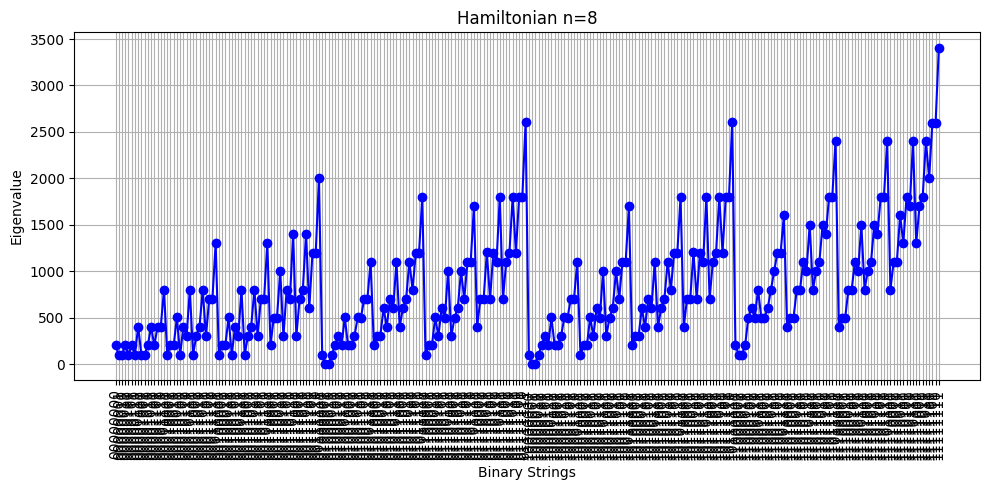

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def foo(binary_string):
    # Example function: count the number of '1's in the binary string
    return get_expectation_value(initialize_state_from_string(binary_string), H_total_JSP)

def generate_binary_strings(n):
    total_strings = 2 ** n
    binary_strings = []
    
    for i in range(total_strings):
        binary_string = format(i, '0' + str(n) + 'b')
        binary_strings.append(binary_string)
    
    return binary_strings

def create_heatmap(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros((2**n, 1))  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Reshape values for heatmap (1D to 2D)
    heatmap_data = values.reshape((2**n, 1))

    # Plotting the heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Function Value')
    plt.title(f'Heatmap of the eigenvalues n={n}')
    plt.xticks([])  # Hide x ticks
    plt.yticks(range(2**n), binary_strings)  # Show binary strings on y-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Function Values')
    plt.show()

def create_2d_graph(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros(2 ** n)  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Create x values (indices of binary strings)
    x_values = np.arange(len(binary_strings))

    # Plotting the 2D graph
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')
    plt.xticks(x_values, binary_strings, rotation=90)  # Show binary strings on x-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Eigenvalue')
    plt.title(f'Hamiltonian n={n}')
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    ax = plt.gca()
    #ax.set_ylim([-1000, 0])
    plt.show()

# Example usage
create_2d_graph(task.num_qubits)


In [12]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

attempting all MUB states over the operator JSP Problem
Energy Landscape:


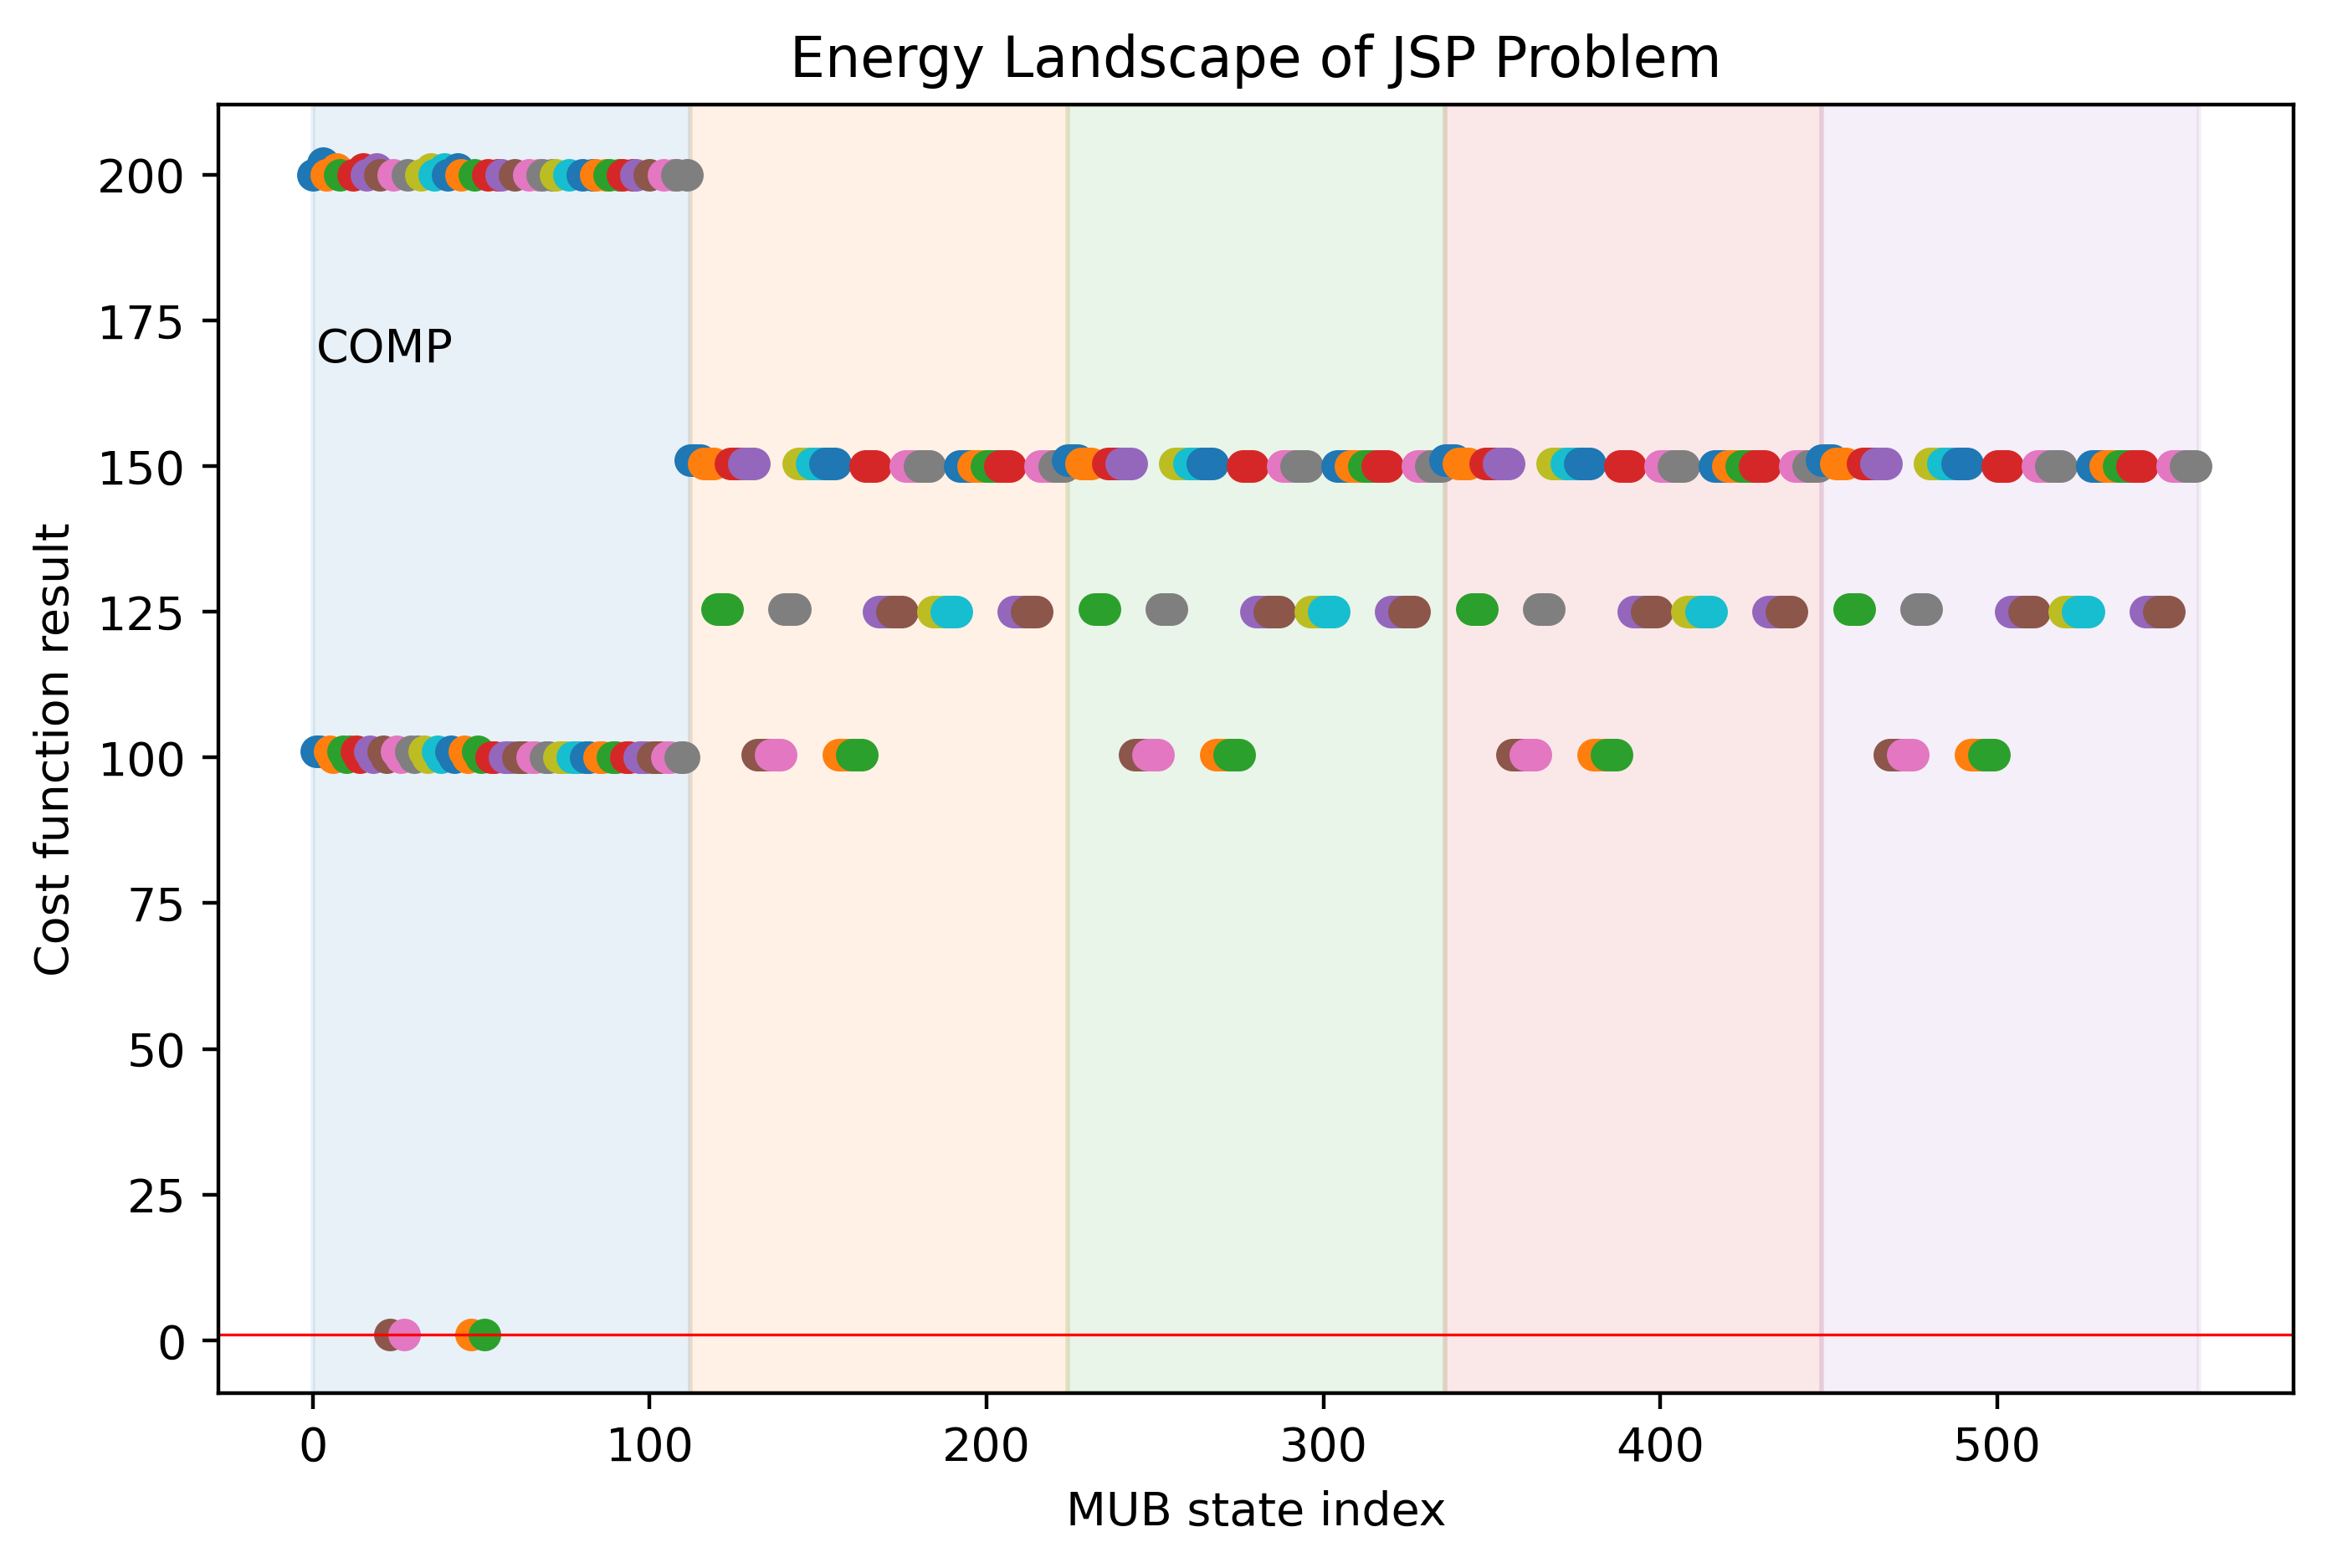

Energy Histogram:


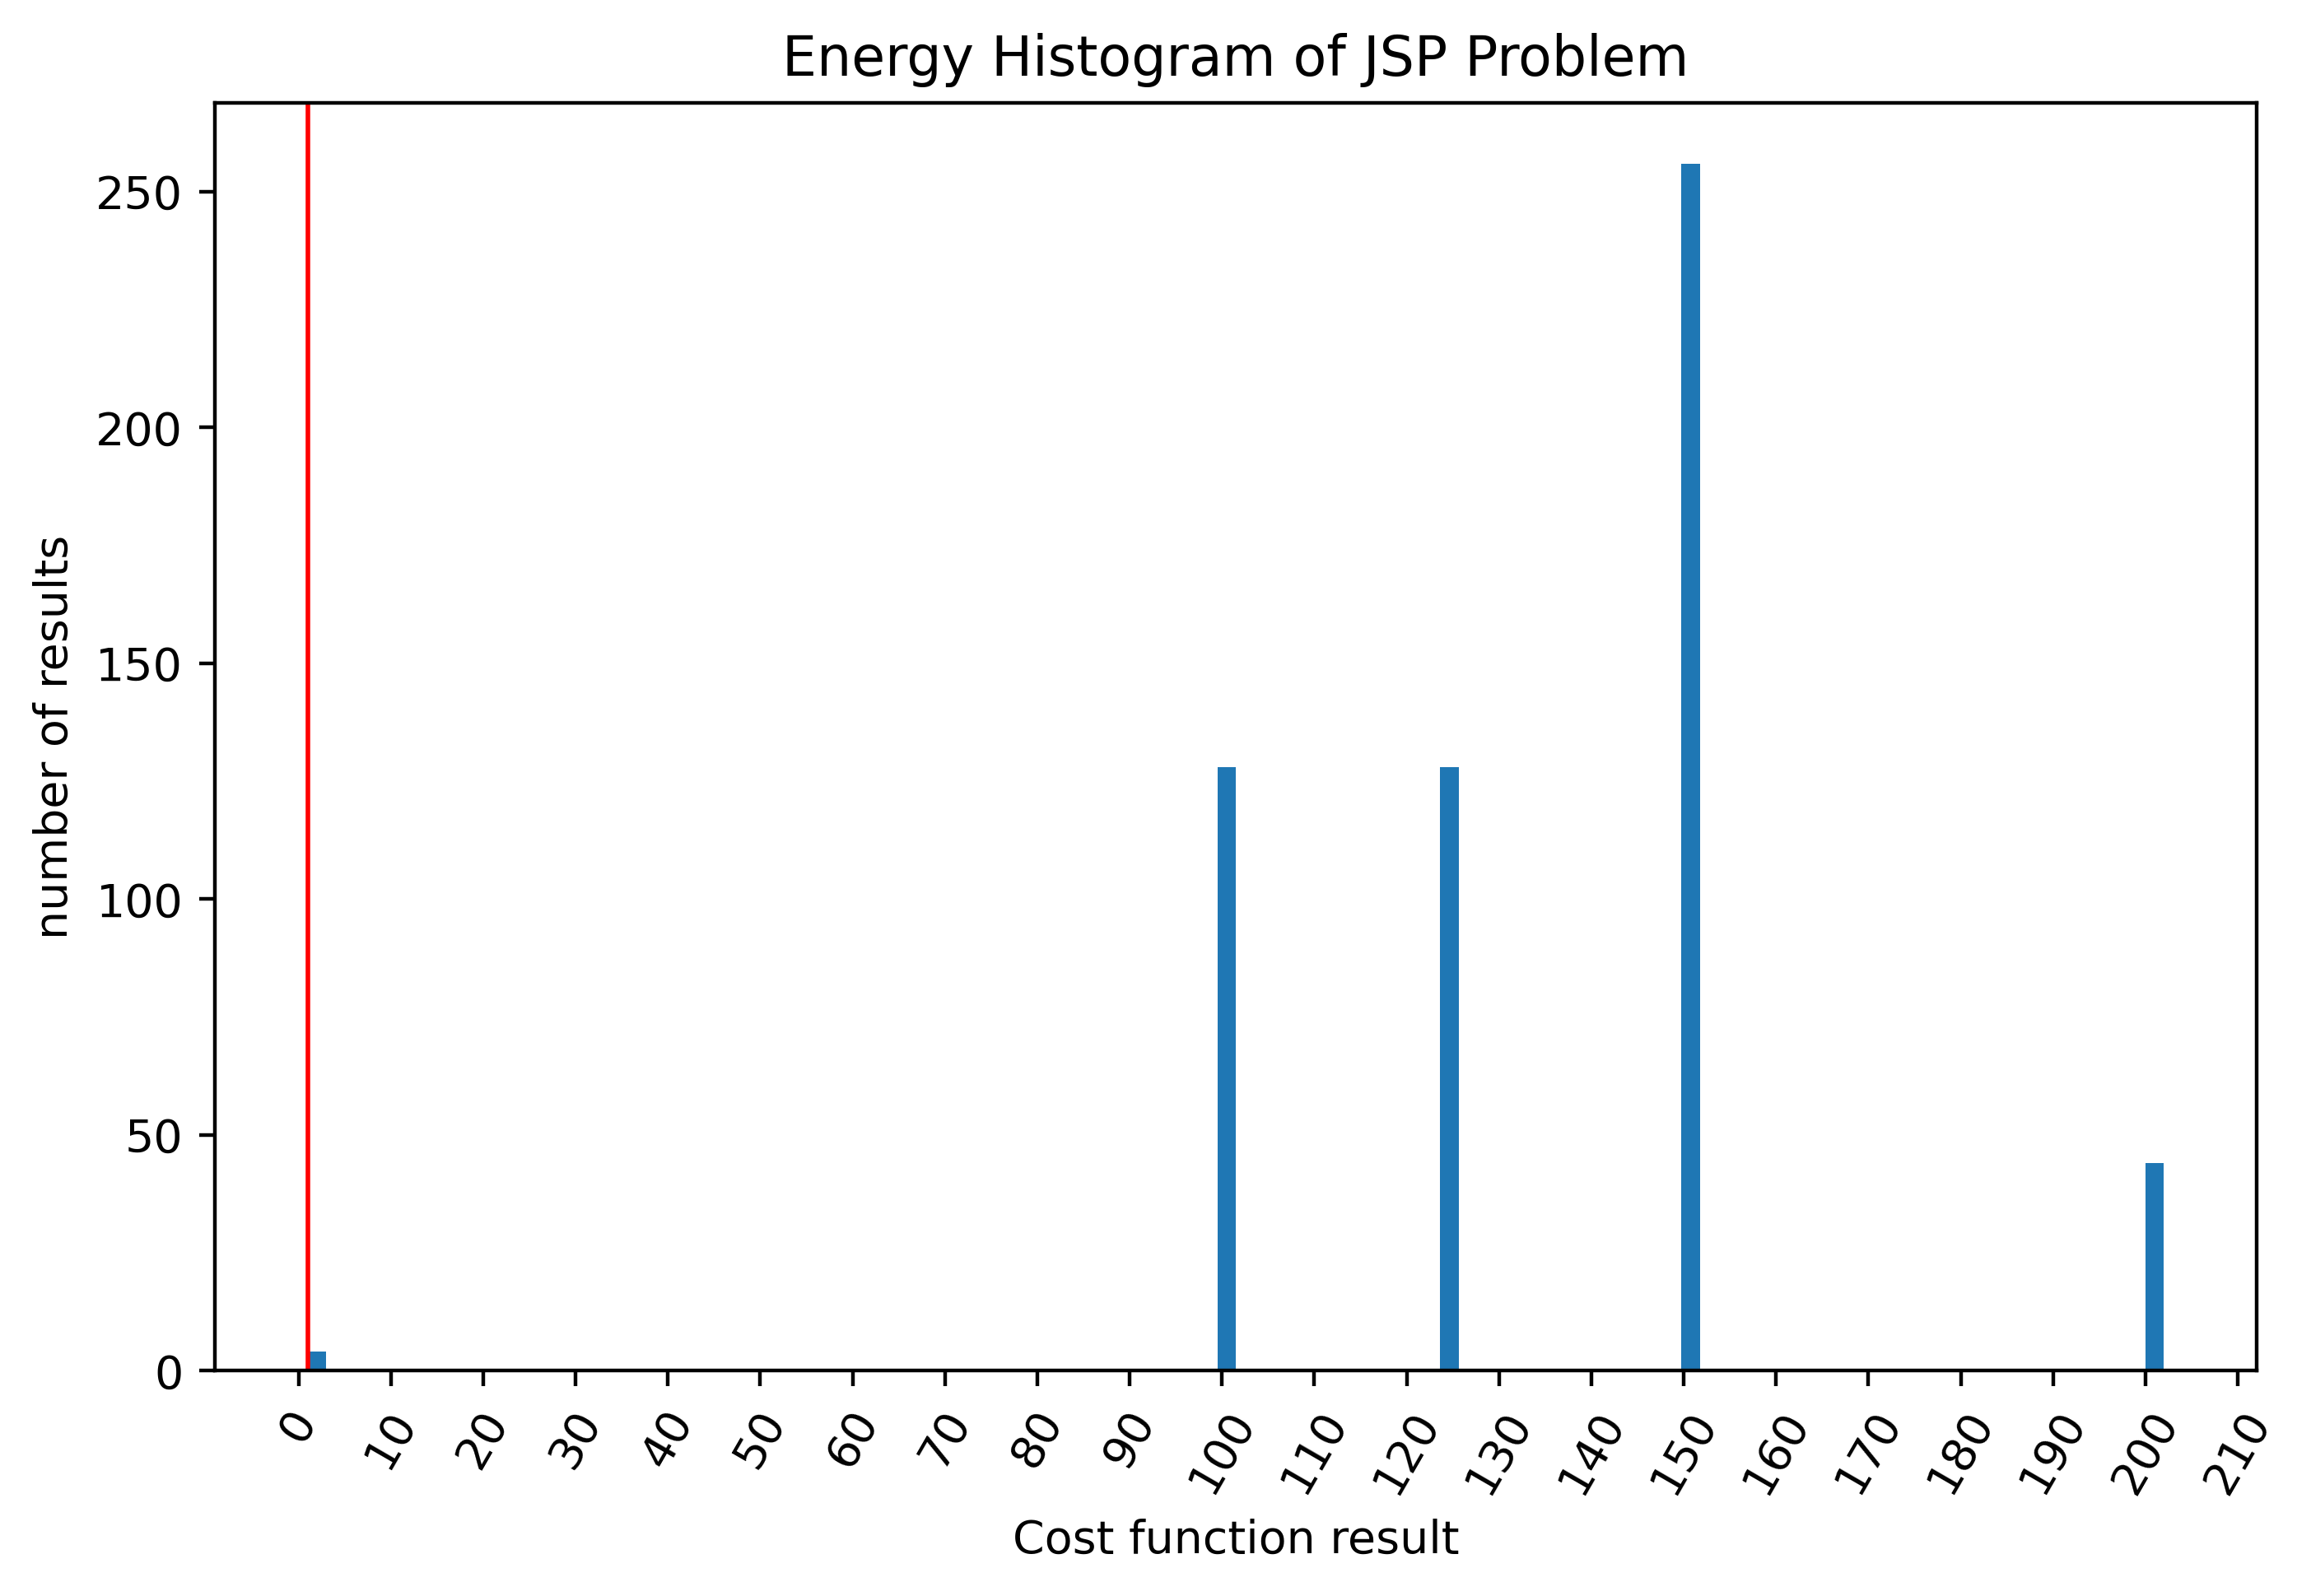

In [12]:
from experiment_utils import *

#####

landscape = run_and_record_landscape(H_total_JSP, 2, "JSP Problem")

**Ordinary VQE Experiment**

In [19]:
# '''
# Local minimum / Barren plateu parameters:
# [ 3.13187972  3.12485043 -1.44129882  4.00258695  1.8533889  -3.12973059
#  -1.08003222  1.32447117 -3.06463937 -1.37484716  3.00077516  2.21082978
#  -0.48120423 -0.65864836 -1.87660719  2.90869065 -0.01450286  0.0056704
#  -1.24626281 -1.18387608  0.84658704  0.143061    1.08438938  3.01307439
#  -2.92390669 -1.35869707  2.22695821 -1.74882826 -1.24884991  1.04685626
#   4.12047077 -0.1012765   3.14070326  0.01168365 -0.26387405 -2.08641117
#  -2.02884714 -0.67421794 -3.14378263 -0.04925929  1.80073301  3.12473985
#  -0.54310333  3.04640342 -1.34794034 -1.14862973 -0.00511756  0.30066454
#   0.011112    3.15367366  1.08694752 -1.66558516 -0.18201067 -0.91444362
#   1.57954499 -1.57272221 -0.98917923 -1.18253121 -3.31701255 -1.3658075
#   0.35165013  1.23242994 -0.80157646 -2.42548444]
# '''
# ### INITIAL THETA [1.0]*ansatz.num_parameters GETS STUCK, INITIAL THETA [0.0]*ansatz.num_parameters CONVERGES

ITERATION 0 - seed = 42
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.43992439229655
Optimal parameters: [ 3.1456893  -0.02252359  3.1585282   2.35118778 -3.14580497  3.44931288
  1.64278245  3.29042524 -3.20484783  1.19685596 -0.53235424  3.51769124
  1.17395228  2.35499699 -1.24211861 -2.4142743   0.01394817 -3.17137321
  1.77789394  2.43191789  2.37619432 -0.00705835  4.7359008   2.42406626
  1.2605342  -0.9512338  -0.0211974  -3.18978699 -0.03596656  1.29620479
  0.65395564  2.9408496   0.01303896  0.04367802 -1.45728561 -1.53701884
 -2.41232386  0.52685126 -1.45704006  1.7467741  -0.27861913  1.87958584
  3.24797478 -0.65743706  1.46855386  1.29018942 -1.60260165 -1.26123381
  3.09787167  0.00699693 -2.19200717 -3.33385228  2.18442154  0.44675676
  1.54339136  1.44267377  1.01655645  0.96645308 -2.13102111 -1.63796476
  0.5495058  -0.66383805  0.99851612  0.67194803]


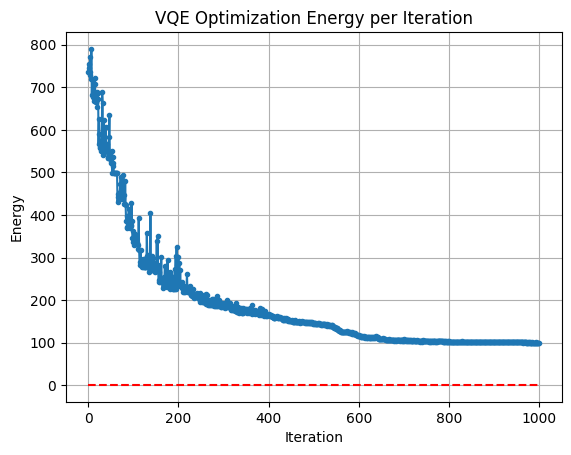

ITERATION 1 - seed = 43
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 151.62284643614217
Optimal parameters: [ 1.57160128e+00 -1.57733433e+00 -3.13861523e+00  3.14205954e+00
  1.66014964e+00 -1.21478149e+00  1.57936026e+00 -6.07423665e-02
 -2.88329373e-03 -3.50174218e-03  3.19481772e+00  3.48938198e+00
 -9.56161379e-01 -1.07572198e+00  2.04141826e-01 -2.71379299e+00
 -1.57239287e+00  3.19533871e+00  1.57142613e+00  3.50412824e-03
  1.38853778e+00  4.55122408e+00  1.79344840e-01  3.18633998e+00
  3.55133031e+00 -3.63784803e+00 -1.72013409e+00  2.65085123e+00
 -1.26529395e+00 -1.20736073e+00 -1.56636796e+00  1.77997346e+00
 -3.13529847e+00  2.83508055e-03 -4.42193529e-03 -3.14640638e+00
 -1.22716400e+00  3.72437463e-01 -1.46051625e+00 -1.15328407e-01
 -2.66319081e-01 -2.48070544e+00  9.17187759e-01 -2.63024514e+00
  2.18904796e+00 -2.57085318e+00  8.93147459e-01  1.97070163e+00
 -1.49872755e+00 -3.13276015e+00 -1.10566102e-02  2.04993994e-03
  1.5948705

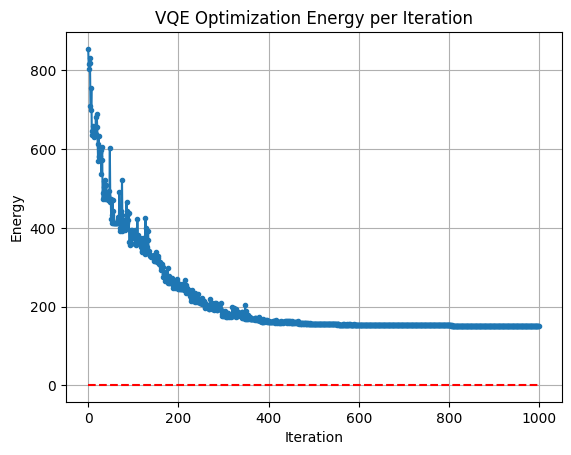

ITERATION 2 - seed = 44
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.54193456356482
Optimal parameters: [-3.14309774 -2.75669267 -0.14313004  4.6409293  -1.57359812  3.05870935
 -1.57901969  0.01696419  2.1459979   1.60211374  3.1381184   0.10159499
  3.10103835  3.38216154  1.4019473  -3.44199529  1.42258524  3.15611973
 -0.05611767 -1.6092175  -1.87034515  1.66149084 -3.12218692 -0.01011297
 -0.15624574 -2.15533951  3.55564898 -0.4507099   1.60562122  2.06147129
 -1.61406036 -2.93314874  2.81007193 -0.26324924  0.02607101 -1.55410423
  3.17061017  0.33802805 -0.06762389 -1.5573058   2.97767886 -0.00733823
  1.2487679   2.11938746 -1.09934126  3.54552986  3.1838676   0.04290075
  1.64526188 -0.42071168  1.50726506  0.05549047 -0.36080982  2.79331454
  0.58259838  1.40827457  3.05141558 -1.35284946 -1.50144    -1.59761427
 -0.87619111  1.27986173 -1.28086774  1.91830942]


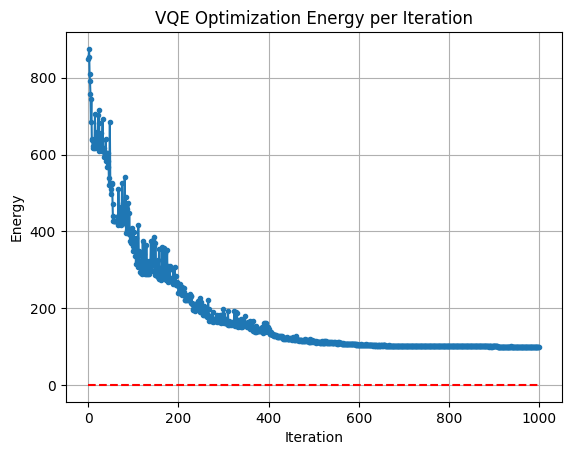

ITERATION 3 - seed = 45
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 41.45881366877372
Optimal parameters: [ 1.70181191  0.01559266  1.63829718  1.62036694  0.0326533   3.30203937
  1.82680559  0.21150423 -0.14022394  1.20418738  3.11779072  3.14486988
  2.83223419  1.3129277   3.22753003 -0.4213034   3.33587341  3.4300117
  1.53351117 -3.20015528 -1.55467312 -1.75315281  2.22506761 -2.53353018
  1.13495534  0.85895212 -0.60571387 -1.63010562 -2.15549461 -2.99122556
  1.46974031 -1.51104664  1.55348882  1.49728421  0.06430768  3.21744733
  0.02812891 -3.12760007  0.03711502 -0.57117419 -1.75538465  3.29106397
 -0.00659853  0.75408942 -2.30300674 -3.14039365  3.07027892  1.63975525
  0.92021379  1.65734367 -1.56904173  1.30663445 -0.04171161  1.51073821
 -1.35966363 -0.39545399  1.37728419  1.46979904  0.1101862  -2.86627495
 -0.32377473  2.83144937 -2.32973499  2.06874014]


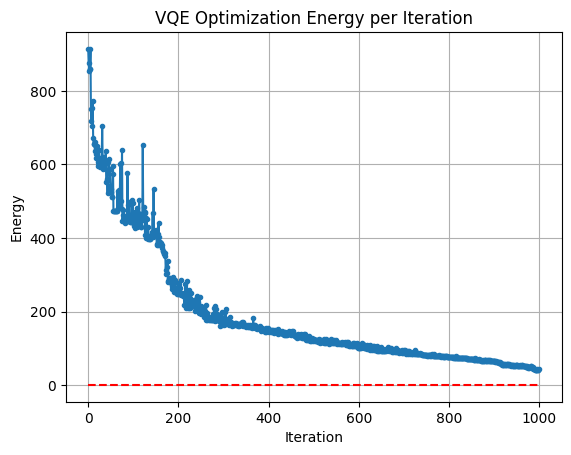

ITERATION 4 - seed = 46
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 36.87209622203704
Optimal parameters: [ 3.13459426e+00 -3.06361470e+00  4.03487341e-02  1.72159359e+00
  4.43106149e+00 -1.60415314e+00  2.75411481e-01  1.97739665e+00
 -1.08207039e+00  3.55822467e+00  3.45491809e+00 -8.09862400e-04
  4.29117541e+00 -3.08623954e+00  2.11332206e+00  1.74662462e+00
 -3.19126039e+00 -1.12724717e+00 -4.22798579e-02 -2.25205086e-01
 -2.48903962e+00  3.38687134e+00 -9.10177426e-01 -2.03993999e+00
  9.04997759e-01  9.09100695e-01 -4.89801782e-01  3.40230574e-02
 -3.23250391e+00  1.59553918e+00  1.47196857e+00  1.94099153e+00
 -2.18040718e-03  3.20155975e+00 -7.28102204e-02  1.40917802e+00
 -3.01314653e+00 -1.76711282e+00 -3.06066446e+00  1.08092843e-01
  1.74777778e+00 -2.40527215e+00  2.14536347e-01 -1.84708869e+00
  1.20600070e+00  3.24074419e+00  4.07518930e-01  2.30686029e-01
 -1.30298803e-01 -1.12252982e+00  2.25108338e-02 -1.89644483e+00
 -3.25510266

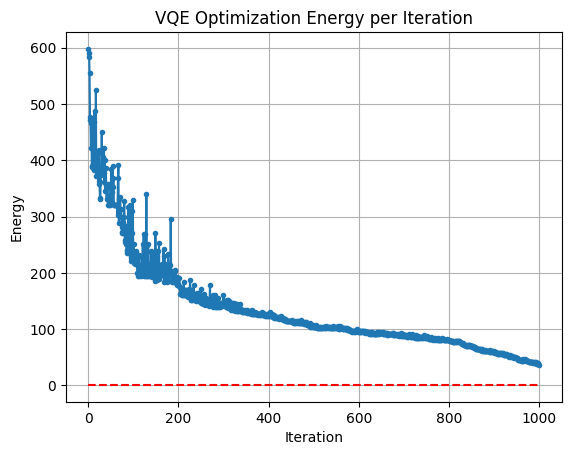

ITERATION 5 - seed = 47
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 104.71711436895765
Optimal parameters: [-3.53076019e-02  3.14402033e+00 -1.00248698e+00 -1.35485106e+00
  3.12804394e+00  4.60701061e-03 -8.04130361e-01  4.64737392e+00
  1.11971976e+00 -1.01081029e+00  2.21562627e-01  2.14527823e+00
  1.07752341e+00  1.75301120e+00  9.58296235e-01 -9.95203167e-03
 -9.35353657e-02  3.18052045e+00  2.24297529e+00 -1.87564360e+00
  5.44360222e-01 -3.08685390e+00  9.33033014e-01 -2.93861471e+00
  3.48333091e+00  1.53235273e+00  2.14975171e+00  2.71447194e+00
  2.25407510e+00  6.55535142e-01  1.22289972e+00 -1.56867650e+00
  2.76092262e-02  3.15467290e+00  3.87221204e+00  2.03971602e+00
  2.61424271e-01  3.29682203e-01  1.44848538e+00  3.42894649e+00
  1.96278904e+00  3.29334030e+00 -2.95028249e+00  5.23053926e-01
 -1.63359241e+00 -1.67994159e+00 -3.31929579e+00  1.71515918e+00
  7.46872019e-03 -3.05489636e+00  4.62418783e+00  1.32448298e+00
  1.2100206

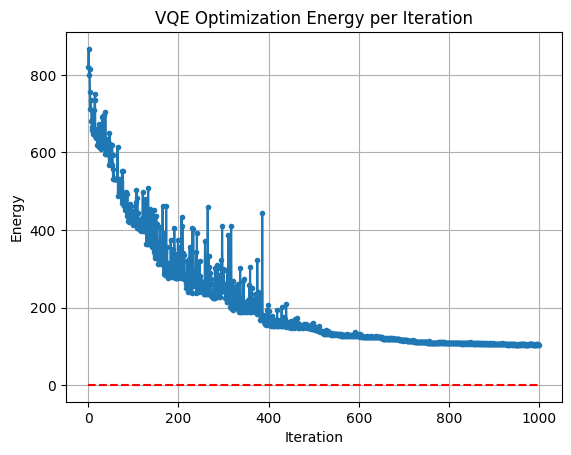

ITERATION 6 - seed = 48
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.1586284076935
Optimal parameters: [-5.36846976e-01 -4.14665552e-03 -1.69207561e-03  1.36866127e+00
  9.00247937e-01  1.55016045e+00  1.58800549e+00  2.07188251e+00
  1.90221389e+00 -1.71347314e+00 -1.52205151e+00 -2.90373997e+00
  1.19867752e+00 -2.62591386e-02 -1.56051483e+00  6.12437375e-02
  1.39463215e+00  2.53289286e+00  1.57806806e+00 -2.87575626e-01
 -3.14195563e+00  1.56255868e+00  1.57139677e+00  6.60650287e-03
 -5.52220336e-01  1.71204324e+00  3.14744676e+00 -2.20174565e+00
 -1.74922016e+00 -1.32146825e+00  2.91437470e+00 -3.13036686e+00
  7.36901927e-01 -1.09284908e+00  1.56451809e+00  1.57446771e+00
  2.51803064e+00 -7.68827945e-01 -1.57428727e+00  5.82606538e-02
  4.13511938e-01 -5.74223865e-01 -3.02644568e+00  4.89932157e-01
 -2.72600036e+00  3.13002682e+00 -3.16911706e+00  4.98678905e-01
  1.56320605e+00 -2.82734996e+00 -1.38317377e+00  3.17440167e+00
  9.81689753

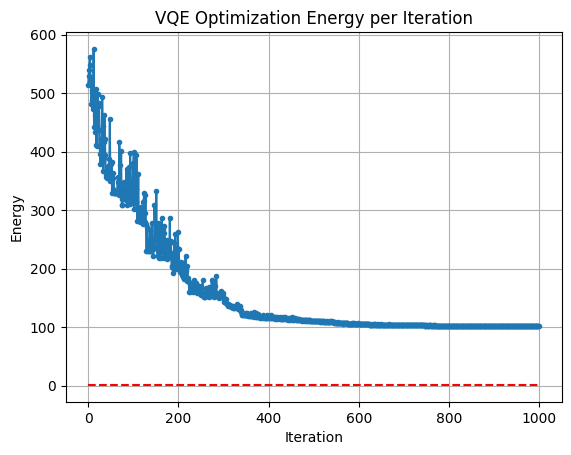

ITERATION 7 - seed = 49
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.30850630044398
Optimal parameters: [-4.19755447e-04  1.54437740e+00  7.77448650e-04  2.42405141e-01
 -5.76970618e-03 -3.13466400e+00  2.10948925e+00  3.79690762e+00
 -1.35312042e+00 -3.02699034e+00  3.45008891e+00  9.81947471e-01
  1.94815804e-02  2.58927309e+00  2.82893478e+00 -1.27118554e-01
 -3.13977297e+00 -2.72370307e+00  2.03807936e+00 -3.07055469e+00
  1.59360409e+00  9.46357721e-03 -1.35660048e+00 -2.84796875e+00
  1.50038071e+00  2.64702647e-01  2.42294693e+00  2.05416484e+00
  1.95702029e+00 -1.35163994e+00 -2.85642087e+00  4.33439078e-01
 -3.15178049e+00 -3.74260665e-01  1.46298261e+00 -1.49453428e-01
  3.05273720e+00  1.82112516e-02  1.40457906e+00 -7.48590508e-01
  1.22489425e+00 -9.18424786e-01 -5.93838048e-01  3.25063708e+00
 -1.88117484e+00  7.25617193e-02 -5.89061796e-02  2.92356463e+00
 -4.13428241e-02 -1.69062978e+00  2.21661233e+00 -1.36795177e+00
  1.6223440

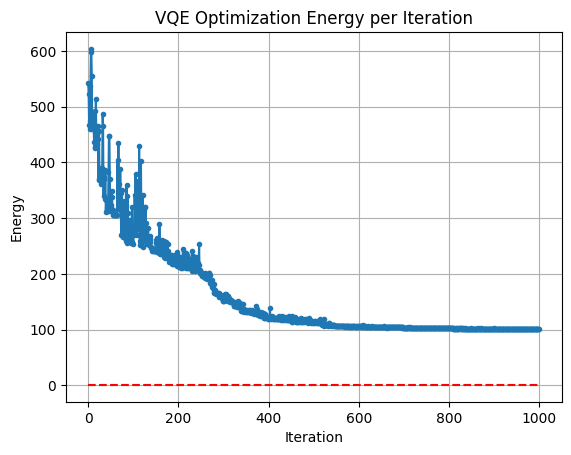

ITERATION 8 - seed = 50
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 10.547026065081049
Optimal parameters: [ 2.7200765   3.23348772  0.38580581  4.68632384 -1.6777817   2.23204043
 -1.07025086  1.41300703  0.38376001 -2.21965789  4.0075337  -0.29035372
 -1.63242495 -1.31566085 -1.88272415  3.22617954  0.83102434  1.89111523
 -1.92948927  0.9223347  -1.58054951 -1.57712918  0.94369467 -3.21179235
 -0.72739187 -3.05913499 -0.12931736 -1.05626319  1.0551484  -0.2862419
  0.9050211  -3.0831565   0.77670054  2.09823912  1.72726443 -2.71772473
 -1.79294836 -0.32455781 -0.73996487 -0.12337677  3.47843911  2.90659716
 -4.3369391  -0.37301105  2.44128946 -1.45504139 -0.56295057  0.07975453
  1.59695335 -1.40300408  3.14621015 -2.11455776 -1.27272187 -1.56969322
 -1.42017167  1.48682726 -0.53706743  1.50228674 -0.03094895 -1.88431163
  2.25887541  2.47320883 -2.77468413 -1.55264244]


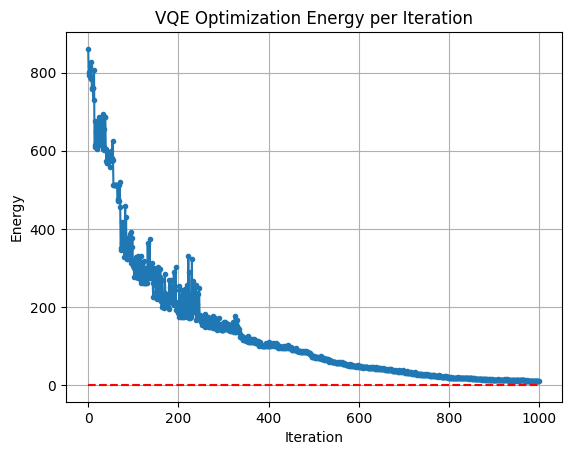

ITERATION 9 - seed = 51
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 8.993252026481986
Optimal parameters: [ 3.14321067e+00  1.72028640e-01 -1.50907437e+00 -1.63293127e+00
  3.19558470e+00 -1.54793972e+00  1.36383594e+00  2.00698161e+00
 -3.83757440e-01  3.87350995e-01  3.10495010e+00  3.23936560e+00
 -1.63550374e+00  4.27122766e-01 -3.98307210e-01  4.70774598e+00
 -4.30087777e-02  9.99136106e-01  4.72885020e+00  1.14056291e-01
  1.57147230e+00 -1.42748499e-01 -2.02653419e+00 -3.39781186e+00
 -1.99707535e+00 -9.50131091e-02 -6.27655748e-01 -8.29813129e-01
 -5.77444618e-01 -1.12596719e+00  1.20716129e+00 -1.43083432e+00
  2.46161036e-04  1.69452458e+00  1.51709477e+00 -3.13731278e+00
  3.09305946e+00 -1.57811876e-03 -2.09352394e+00 -3.51566806e+00
  1.23953626e+00  2.61194876e+00  4.26876596e+00 -2.00754007e+00
  2.55695235e+00 -1.42417514e-02  1.48715216e+00 -1.36537138e+00
 -3.02739444e+00 -1.68180906e+00 -2.52471976e+00 -8.04490316e-01
 -3.07668562

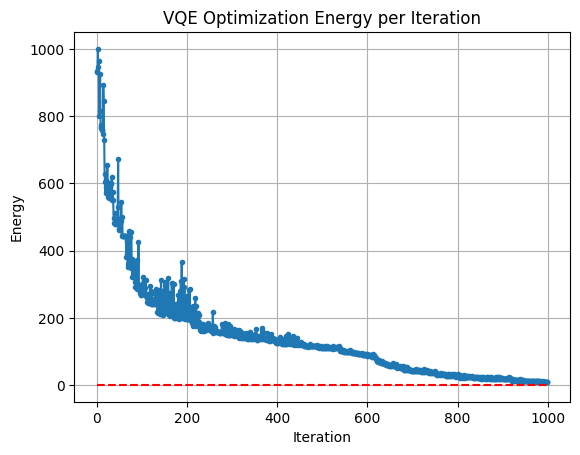

ITERATION 10 - seed = 52
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 91.58029212133815
Optimal parameters: [-0.01302251 -0.02054845 -0.00792172 -3.14645204  0.47036942  3.92937869
  0.1896797  -3.01816688 -0.12132171  4.09535088  2.65753251  2.05721796
 -1.39875036 -2.18314831  2.40711694 -1.23660503 -0.01636787 -0.88446252
  1.55734608 -1.61487112 -0.04213743  1.77560975 -0.78644639  1.49996338
  0.6492652  -1.69889669  3.12895756 -0.00834433 -0.07025348 -0.54607807
  3.58444297  0.13642661 -0.08485797 -0.82899697 -1.57381867  1.56088584
  1.59321761 -1.17396035 -0.57388932 -3.20458317 -2.44432513  3.00492411
  0.22653888  1.23230749  0.53451192 -1.24149396  1.1293066   3.16880337
  0.05845164 -1.50549815  1.48009064 -0.01420507  0.07526356 -1.66012007
  0.81694497  1.76364786 -0.96062046  1.41130462  4.14499871  0.15274735
 -4.33847247  0.70911888  0.62705841  1.35657854]


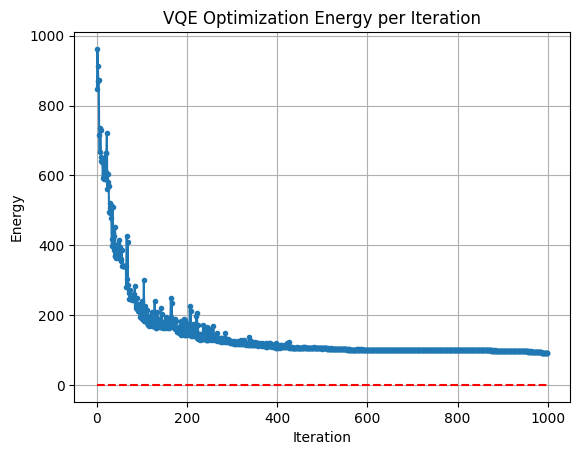

ITERATION 11 - seed = 53
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 11.632801646815246
Optimal parameters: [-1.5657938   1.30652683 -0.38017774  3.13867468 -1.61280637 -0.02296443
  1.53986794  1.93231383  3.10335988  3.49957659 -0.69864472 -2.03018892
  0.38198597  1.55019178 -1.23496747  1.58101983  1.5612573   1.62809355
 -1.71862263  1.54205812 -0.99889343 -3.79010976 -3.23893328  1.44213091
  2.7473872   2.58733013 -0.37742061  3.13041785  4.10989196 -0.73046148
 -2.96876064  2.87616918  1.40970057  3.12945351  2.63080436 -2.92266701
  3.1296135   1.53171081  0.00733448  1.92807177  1.39709249  0.00595338
 -0.44523264 -2.9402151  -3.11022842  2.70302766 -0.01021     1.6340738
  1.62900548  1.71105111  0.89833148  1.49813999  1.54358278  1.58477168
  1.17010114  1.4218546   3.18537931 -0.91075539 -0.47713624 -1.70275372
 -1.63701618  0.55822718 -0.58230885  2.05241398]


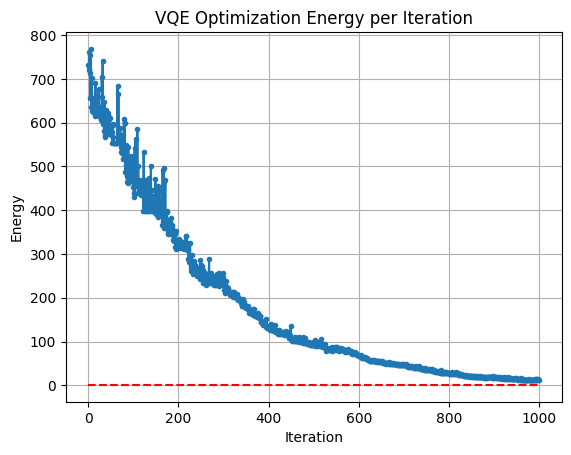

ITERATION 12 - seed = 54
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 108.89929418641827
Optimal parameters: [-3.18311174 -0.32081939 -1.0369949   1.60632135 -3.14210754  0.05857156
  1.5903545  -1.58566909  2.71139092  4.32251231  0.02786987  2.45848274
 -0.39038114  0.34611015  1.05988395 -0.69640225  1.58019085  1.63580831
 -1.61372297  0.96731362  2.77834694  3.04142244 -3.06349999 -2.21672839
  0.06074349  1.34625498  3.04063697  2.3780424  -2.41991927 -0.96377771
 -3.75902652  0.17399479  1.56855941 -1.62907501 -0.11629206 -2.15115513
 -3.30395564  0.89473588  3.11159164  0.05429624 -0.88463357  2.34483419
  2.77262256 -0.07772312  1.58477741  1.43749827 -2.35528203 -2.20702785
 -1.43822517  0.05792106 -1.55738946  1.47375469  4.32897891 -2.39528514
 -4.69201396  0.90086282  1.39990727 -1.44931945  1.96578169  1.692699
  1.75234415 -2.25273557 -1.47987384  4.19969984]


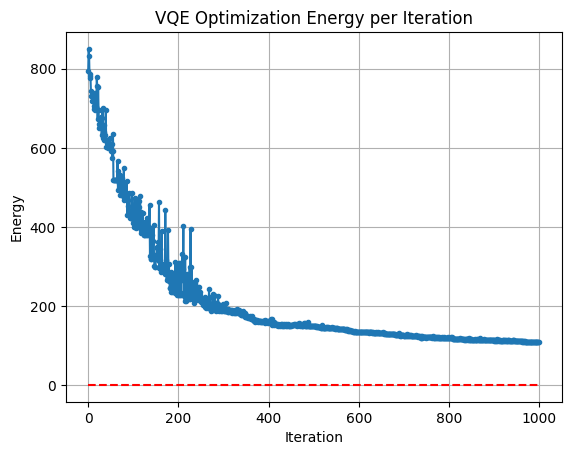

ITERATION 13 - seed = 55
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 100.26826230017288
Optimal parameters: [ 3.14184881e+00  3.14600448e+00  1.68952817e-02 -1.98421862e+00
  3.63388001e-02  3.14927023e+00  1.03316724e+00  2.66319282e+00
 -3.77972767e-01  1.33885542e+00 -1.87804339e+00  5.33228368e-01
 -3.97564915e+00 -6.30925973e-01 -1.81532211e+00  3.78920680e+00
  3.36494690e-03  1.19694960e-03  3.10925044e+00 -1.14097717e+00
 -8.50758525e-01 -6.34756406e-02 -3.20345534e+00 -3.67443059e+00
 -1.26513811e+00  9.81958884e-01  1.22061374e-01 -2.78312199e+00
 -1.68453890e-01  2.06499442e+00 -1.24389929e+00 -2.02319680e-01
  2.88465502e-04  3.14088311e+00 -9.12731325e-02  1.02185049e+00
 -1.11189750e-01  3.14701870e+00  6.18611138e-01 -1.63661736e+00
  3.27686348e+00  2.54740723e+00  2.52478639e+00 -2.43568227e+00
  1.19670960e+00  4.02844741e+00  3.20321023e+00  2.83769804e+00
 -3.13525322e+00 -3.15082993e+00  1.42386832e-01 -1.07095480e+00
 -1.962653

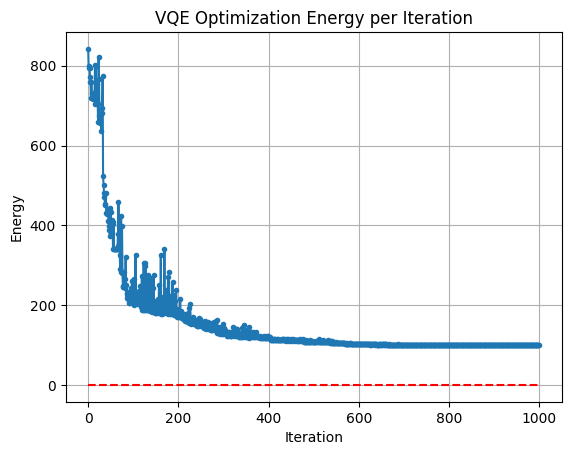

ITERATION 14 - seed = 56
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.37228461744327
Optimal parameters: [ 3.74277144e-02 -1.39792406e+00  3.59364903e+00  2.09590245e+00
  2.03583572e+00 -1.57367707e+00  3.15749188e+00 -6.56601834e-01
  2.92694515e-01 -1.84838394e+00 -2.26635853e+00  2.46639121e+00
  1.51638294e+00 -3.25373595e+00  3.15959120e+00  2.58696919e+00
  8.66647514e-03 -2.22685480e+00 -1.68786303e+00  1.52343288e+00
 -1.52241532e+00 -2.87244511e-01  4.54188340e-01 -9.94099030e-01
  4.69406470e-01  1.94219070e+00 -7.98516831e-02  2.67712811e+00
  3.39779436e+00  1.55704594e+00  1.45519984e+00 -3.18822717e-01
  6.24901756e-02  3.44398408e+00 -2.24193875e+00  1.27153382e+00
  2.92735061e+00 -1.09800535e-01  1.42694799e+00  8.37865014e-03
  2.50274283e+00 -1.14137640e+00 -1.28474204e+00  1.97297943e+00
 -5.87227206e-01 -5.10643122e-01  2.09022240e+00  2.74722547e-03
 -4.33684079e-02 -1.30642627e+00  1.03907909e+00  1.46652129e+00
 -7.238221

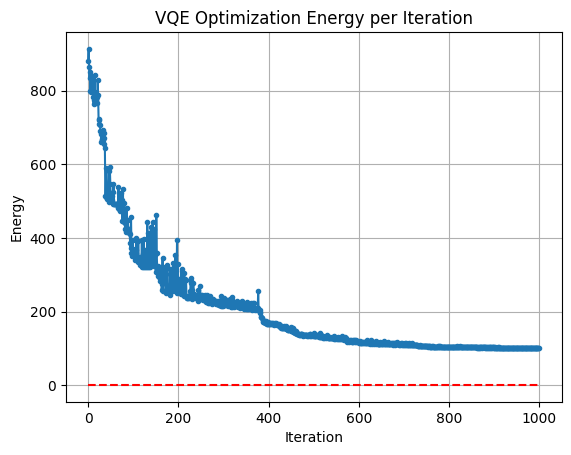

ITERATION 15 - seed = 57
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 2.116596984504319
Optimal parameters: [ 1.97553093e-03 -1.04266307e-02  3.13465750e+00 -4.26390468e-04
 -3.89857197e-02 -2.75780799e+00 -6.87673076e-01  1.50774971e+00
 -1.33178570e+00 -1.05102177e+00  4.01582281e-01  1.25929333e-02
  3.56771268e+00  4.71513501e+00  1.39612115e-01  1.40378627e+00
 -3.39104054e+00 -1.57163646e+00 -1.47151271e-02  1.50097721e+00
 -5.23437459e-01  1.57427434e+00  1.77502970e+00  9.61554975e-01
  2.74385117e-02  7.84364193e-03 -2.25594125e+00  3.14411059e+00
  3.14214966e+00  1.64362737e+00 -1.68023291e+00  1.65664001e+00
  3.22759015e+00  1.64158788e+00 -1.64899024e+00  1.56431329e+00
  1.57474229e+00 -1.77910505e+00  3.18082370e+00  6.49639654e-01
 -8.27077859e-01 -2.24032484e+00  2.25320431e+00 -2.76625649e+00
  2.76948983e+00 -2.00158157e+00  8.21722331e-01 -2.83779383e+00
 -8.11171222e-02  1.50325926e+00 -6.44437847e-03  1.55584680e+00
 -5.9476472

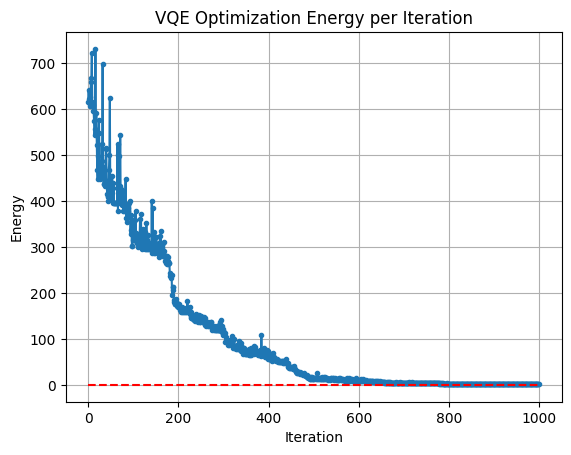

FOUND GLOBAL MINIMUM
ITERATION 16 - seed = 58
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 2.63561514793511
Optimal parameters: [-1.58201702e+00  1.58747806e+00 -1.55158476e+00 -1.65811077e+00
  2.50674583e+00 -1.57400816e+00 -2.20687685e+00 -1.49028763e+00
  1.23589801e-02  3.14012064e+00 -1.28342513e-03 -4.62723662e-03
  3.68987516e+00 -4.02040082e-02 -1.21098200e+00  1.69229397e+00
  4.71594930e+00  1.57046914e+00 -1.57912378e+00 -1.55913887e+00
  1.57673407e+00 -3.48376685e+00  1.20247912e+00 -3.29180721e+00
 -1.71967734e+00  2.79878172e+00 -1.42235269e+00  9.36213745e-01
 -3.16303819e+00 -1.50449936e+00 -1.39914251e+00 -1.79789100e+00
 -9.05370796e-01 -1.21009509e-02  3.13391148e+00  3.13537389e+00
  3.21311966e+00 -2.54346222e+00  5.77520944e-01  8.56569917e-01
 -2.04440396e+00 -1.13974702e-01  2.84074921e-01  2.36919556e+00
 -1.10669399e+00  2.96582441e+00  1.21402352e+00  2.79966394e+00
  2.69164507e+00 -4.56385112e-01  3.14638573e+00  3.1419

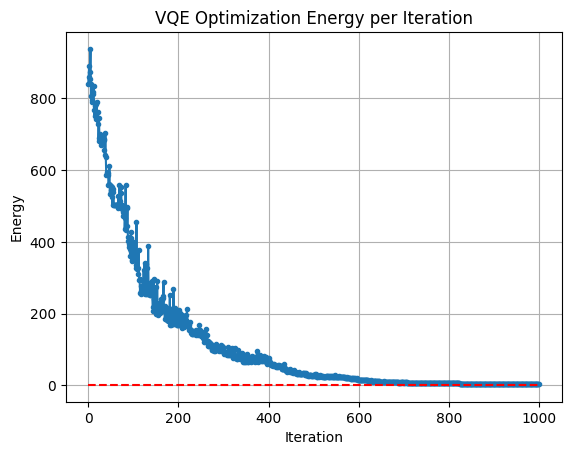

FOUND GLOBAL MINIMUM
ITERATION 17 - seed = 59
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 10.176197347560565
Optimal parameters: [-2.31251281e-03  3.14532707e+00 -1.49125481e+00  1.44112040e+00
 -1.40022107e-02 -1.57326347e+00 -1.53148529e+00  3.04614349e+00
 -1.77947333e+00  1.66267390e+00  6.61353331e-01  1.68844402e+00
 -1.92129346e+00  1.18317935e+00  9.62774828e-01 -2.33732617e+00
 -1.66520049e+00 -1.54452409e+00 -5.96721626e-01 -1.23111600e-01
 -1.24271711e+00 -2.84411674e+00  2.25620520e+00  1.77560672e+00
 -9.31858760e-04  3.42007434e-02 -2.46387078e+00  1.50549286e+00
  3.09842907e+00  2.75758095e+00  1.56002101e+00  3.19028634e+00
 -1.44389220e+00 -1.54134766e+00  4.72662900e+00 -1.31047723e+00
  2.11144619e-01  3.15000023e+00  2.55474888e+00 -1.54061278e+00
 -2.61478769e+00 -8.04947722e-01 -3.92403051e-01 -3.59018445e+00
 -2.14136522e+00  5.20941578e-02  1.45776967e+00  2.08937358e+00
  1.63272285e+00 -3.24001510e+00  3.74427568e-02 -1.61

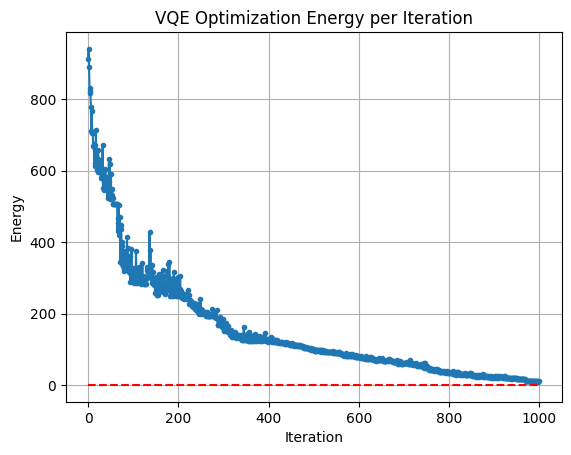

ITERATION 18 - seed = 60
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 1.8390328162624558
Optimal parameters: [ 1.36407264e-02 -3.14521082e+00 -3.14346392e+00  3.14183561e+00
  3.14470633e+00  1.55509468e+00  2.92437988e+00  4.60148548e+00
 -5.88861975e-01 -1.03050307e+00  2.02978837e+00 -9.87597698e-01
 -1.07404668e+00  2.27092644e+00  1.04762166e+00  5.83288468e-01
  1.59831537e+00 -1.64217646e+00  1.12042012e+00 -1.67726750e+00
 -1.57399574e+00 -1.75816786e+00 -3.75499227e+00 -1.31294320e+00
  3.52976126e+00  3.14289567e+00  3.16174909e+00  3.12211920e+00
  7.83368673e-03  2.55053594e+00 -2.39287734e+00 -3.77632319e+00
 -1.70925531e+00 -1.56085457e+00 -1.58510870e+00  1.58103356e+00
 -1.56160344e+00  1.56738993e+00 -1.86127763e+00  1.11911985e+00
  4.35934234e+00 -1.58654585e+00  3.49629621e+00 -1.88938562e-01
  2.17072753e+00  3.95374764e+00  4.02321091e-02 -7.16437287e-01
 -1.66891962e+00 -3.09381167e+00  3.06597737e+00  4.26670645e-01
  3.228043

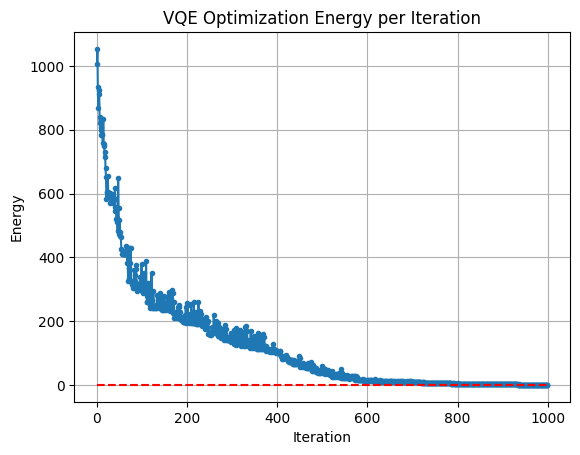

FOUND GLOBAL MINIMUM
ITERATION 19 - seed = 61
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 107.49466766587449
Optimal parameters: [ 1.78111743e-03  2.01454259e+00  1.26045000e+00  3.22174319e+00
  9.23481268e-03  3.38298251e+00  3.89573866e+00  3.20749931e+00
 -2.68312881e+00  7.03303746e-01  9.86643698e-01  9.88193675e-01
  9.40330846e-01  3.22281551e+00 -5.31178822e-01  7.70000356e-01
 -1.52083969e+00  3.20325949e+00 -1.43948817e+00 -3.09585903e+00
  3.19673970e+00  1.99043360e+00  2.04515833e+00  1.34323962e+00
 -3.13564500e+00  4.15304881e+00  9.43223468e-01  2.17354551e+00
 -1.05611211e+00 -1.79344237e+00  1.35578140e+00  2.96202599e+00
 -1.60623982e+00 -1.49928427e+00 -1.06909828e-01  9.79213566e-02
 -1.48078298e+00 -2.05211216e+00 -2.98518927e-01  7.44320115e-01
 -7.96078469e-01  1.96212340e+00 -1.21195906e+00 -4.82198344e-01
  4.51118843e-01  2.65280063e+00  1.96907232e+00 -3.44230344e-01
  4.44822314e+00 -4.73426904e-02 -2.26931362e+00  1.50

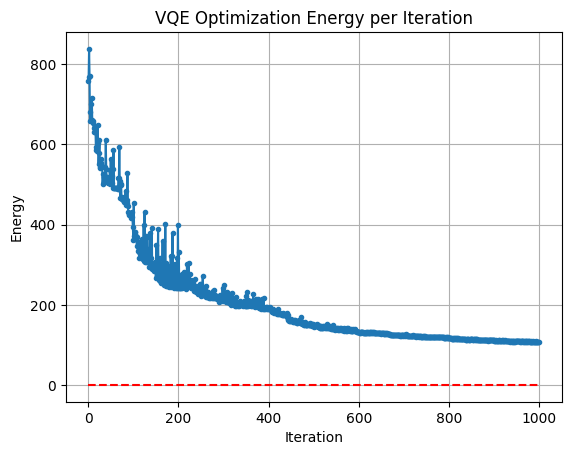

ITERATION 20 - seed = 62
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 107.53889062546197
Optimal parameters: [-1.43989889e-02  1.89323757e+00  1.76054868e+00  1.12387665e-04
  2.97852592e+00  3.13202665e+00  1.00590748e+00  3.27897973e+00
  3.34952035e+00 -2.85573167e+00  2.54134588e+00 -2.16445212e+00
 -1.60036160e+00  2.19873841e-01 -3.32541374e+00  7.72271395e-02
 -9.01619084e-03 -1.09533231e+00  2.58293725e+00  2.06917202e+00
  3.14057745e+00  1.34117069e-02  1.37180850e+00 -2.76062329e+00
 -1.44536065e+00 -3.74673355e-01  1.57990059e+00  3.24345453e-01
 -2.03727811e+00  6.25610017e-01  1.61958165e+00  1.13038470e+00
  3.17484437e+00 -3.47877323e-01 -5.03706382e-01  3.29605257e+00
  2.99450750e+00  1.57482372e+00 -3.47158094e+00 -2.42687705e+00
  4.12911888e+00 -2.53204665e-01  2.04506369e+00  1.76922782e-02
  3.07494761e+00 -3.13332828e+00 -1.03242057e-01 -1.29927222e+00
  3.13363308e+00 -9.04081935e-01  8.29259609e-01  1.85290854e-01
 -1.018100

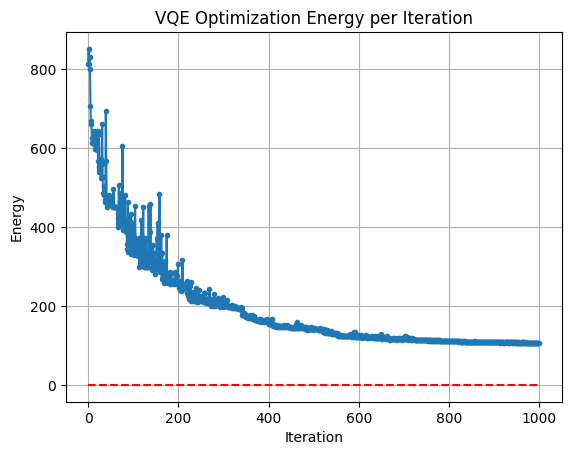

ITERATION 21 - seed = 63
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 3.9255949543623827
Optimal parameters: [ 2.22445668e+00  3.12650993e+00 -3.16335785e+00  5.44030633e-02
 -3.21897635e+00 -3.16414688e+00 -1.41245021e+00 -2.72729054e+00
  1.05012243e+00  1.77685430e+00  1.03837315e-01  7.49872704e-01
 -2.85850628e+00 -2.07580894e-01 -2.26840686e+00 -1.37766657e+00
  4.82443537e-03  2.31756899e-02  1.58162184e+00  1.55570171e+00
 -1.59891019e+00  1.52401714e+00 -3.56154217e+00  1.35930352e+00
 -9.19385147e-01 -2.36262802e+00  3.14600294e+00  9.86208661e-03
  8.67981653e-03  3.15006920e+00  7.76697729e-01 -8.70114187e-01
  1.92629566e+00  6.22176148e-02  1.55804460e+00 -1.57592287e+00
 -1.52964508e+00  2.10988281e+00  1.10653363e-01  1.28332257e+00
 -7.75384901e-01 -7.99417041e-01 -5.26379007e-01  3.68552349e+00
  1.71442966e+00 -3.05083653e+00 -3.10972164e+00 -1.48898895e+00
 -2.77575842e-01 -2.54020305e-01 -3.11994262e+00 -2.23870107e-03
  3.196860

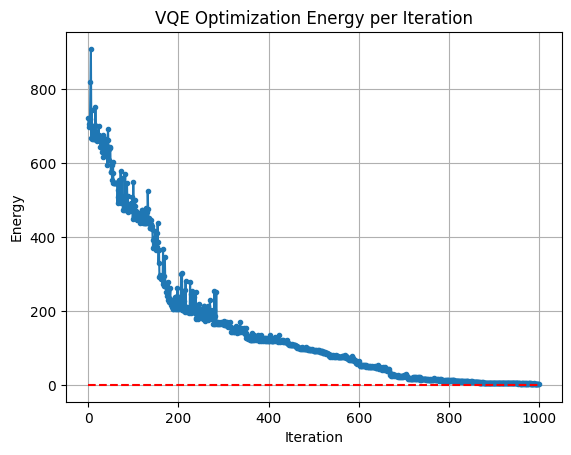

FOUND GLOBAL MINIMUM
ITERATION 22 - seed = 64
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 52.50413292042708
Optimal parameters: [ 3.13659991e+00  1.38002971e+00 -3.15558855e+00 -1.55411368e+00
  3.14937865e+00 -3.13251864e+00  2.86882710e+00  1.61914790e+00
 -3.21103106e-01 -3.07060838e+00  4.92241665e-01  8.19124735e-01
  2.43490674e+00 -2.67702217e+00  2.18193450e+00  2.97415292e-01
  9.57999797e-02  2.60919352e+00  2.10723216e+00 -2.95960177e-03
  5.52502796e-03  1.56934544e+00  1.82300433e+00 -3.16392187e+00
  4.11058714e+00 -3.37107572e+00  1.52902289e+00 -1.64502794e+00
  3.32380041e+00 -1.56804665e+00  2.66243713e+00 -1.89189149e+00
  1.71552038e+00  7.23636206e-02  2.63434210e+00  1.02266024e-02
 -1.57905212e+00  5.19403492e-03  1.55979646e+00  2.26947768e+00
  9.41465200e-02  4.48260024e+00 -1.59532038e+00  3.14005940e+00
 -3.12414359e+00 -3.13533964e+00  2.15477712e+00 -1.08784246e+00
 -1.27107280e+00 -1.48344553e+00  1.45881575e+00  1.600

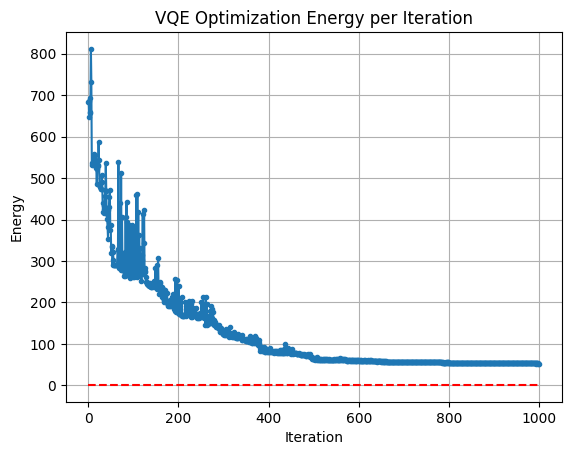

ITERATION 23 - seed = 65
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 112.75977208505269
Optimal parameters: [-2.34228531  0.80293999 -0.14409051 -0.08209348  3.09736967  1.08743945
 -1.55211523 -3.25774187 -1.67649385 -1.89114481  0.51471712 -1.84339156
  1.96035526  1.2804418   0.15981218  3.84136737  0.901055   -1.07186977
  2.9121284  -1.47971734  0.13504564  2.49902461 -1.75488792  1.47365278
  1.20232798 -0.26908967  1.52014859 -3.08621906 -0.76379286  3.65381166
 -1.93169204  2.74671151 -2.81669091  3.54141389  2.7415674   1.61586019
 -1.6709019  -3.54770244  2.85265982  1.56998304  0.87500929  2.06527438
  0.14382219  1.27398026 -2.09795864 -0.29962802 -1.9509899   0.14721663
  0.86198333 -1.16513626 -1.96186133  2.19182065 -2.82318385  1.56634463
 -1.86184206 -1.74690281  2.8185399  -3.25831824  0.50578364  4.89857795
  1.70078537 -0.44534653  2.13121071  2.49964649]


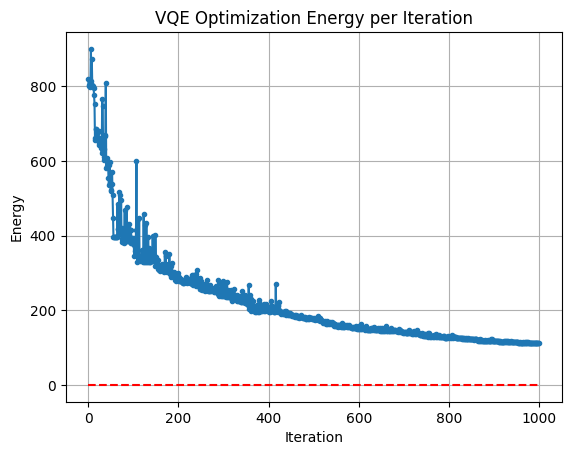

ITERATION 24 - seed = 66
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 12.925224115844006
Optimal parameters: [ 3.11409326e+00  1.54698927e+00 -6.28798402e-01  1.56566333e+00
 -1.31477922e-02  1.60449281e+00 -2.08529191e+00 -2.62663577e-01
 -7.03795657e-01  3.53920667e+00  3.13868141e+00 -1.26380708e-02
 -1.26690084e+00  1.63388897e+00 -1.54881255e+00 -5.20596963e-01
 -2.12816232e+00 -2.83658012e-02 -2.06036344e-01 -1.33822532e+00
 -9.13816878e-01  1.19561457e+00  1.50270456e+00 -1.98383204e+00
  1.47489727e+00  3.73806521e+00  2.72118877e-01  1.48032918e+00
 -1.47384298e+00  3.06711731e-03  2.40467935e+00  3.28424290e+00
  2.43691358e+00  1.57295682e+00 -5.33507258e-02  1.69180609e+00
  1.16137423e+00  3.15836638e+00  2.37111391e+00  1.07564193e-01
 -1.99044152e+00 -1.95101760e+00  1.74431537e+00  3.02131873e+00
 -4.31846896e-01 -3.17447132e+00  1.45986193e+00 -2.14203575e+00
 -2.07776540e+00 -1.63303381e+00 -3.32911154e+00  2.82048081e+00
 -1.227920

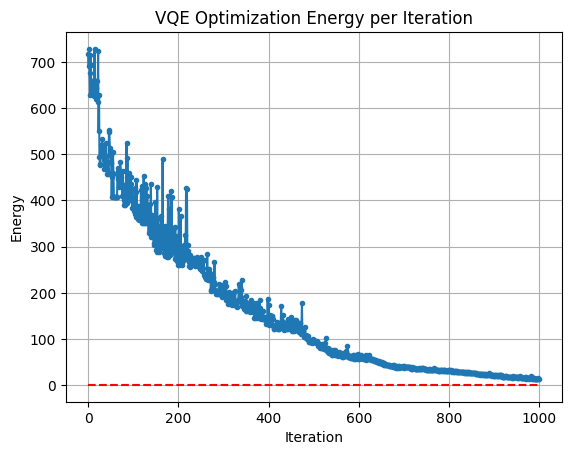

ITERATION 25 - seed = 67
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 50.44473622355505
Optimal parameters: [-0.00386717 -3.04399364  1.19256812  0.00874979  1.59349502 -0.04769248
 -0.14148766 -1.18199658 -1.27932324  3.46592166 -1.7425007  -3.23958104
  2.82981707  3.46417095  3.44366882  2.34182213  0.00811642 -1.58355154
 -1.7591736  -1.07440179  1.84444734 -0.28525623 -0.25289942  1.2367222
 -1.82710402  0.07623131  2.08655734 -3.1997498  -1.24102942 -0.4075413
 -0.82218574  1.57613743 -3.12933439 -1.52606384 -1.52185317 -0.32965449
  3.16793436  1.35981959  2.91518748 -3.78658039  0.02734369  0.91504089
  0.70532767  1.91637118 -0.01469522 -1.54317176 -2.25112444  0.61076664
 -3.128498   -1.57205678  0.04151153 -1.90012948 -1.54896185 -1.5611879
  1.13122577  1.57372281 -2.09736751 -0.59938482 -1.09075503  1.78647411
 -0.46457397  2.78174049  1.2184834  -2.16335398]


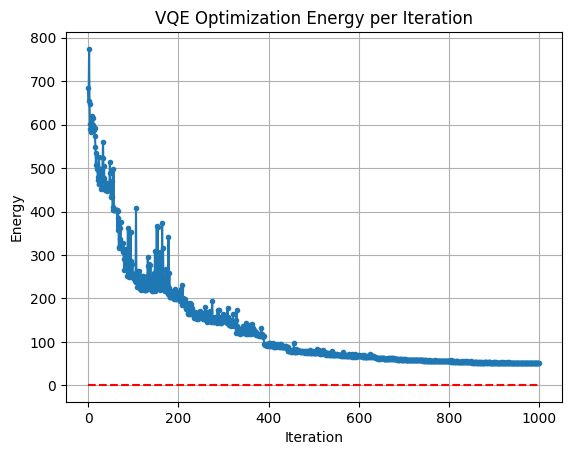

ITERATION 26 - seed = 68
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 46.727114145405224
Optimal parameters: [ 0.02614173  3.13916004 -0.03572423  1.88155306  2.97311837  1.56617052
 -3.15803939  0.36338099  1.24910327 -2.27861482 -1.79888935  2.24993778
  4.20961522  0.98066779 -0.11838799 -3.44336056 -1.06557272  1.5185008
  1.23989669  3.68914311 -1.948059   -2.04952473 -0.68349739 -1.88245973
 -0.10556024 -3.12815032 -2.85041312 -1.32435767 -0.69335288 -2.08022299
  2.43992366  0.06876789  1.14934918  1.68809274  1.58766254 -1.58079929
  0.12685945 -0.06934412  0.0904033   3.15311547  0.15815872  0.83856145
 -0.13614695  0.09669442  0.53864191 -3.04012813 -1.59745652 -3.17379505
 -1.10720375  2.78071878 -0.03801411  3.49560198 -0.33977292  1.62445641
  0.21764032 -1.9474653   1.43293158  0.21848905  2.14029566  0.82883422
 -1.85132279 -2.34298261 -0.06147323 -0.45261393]


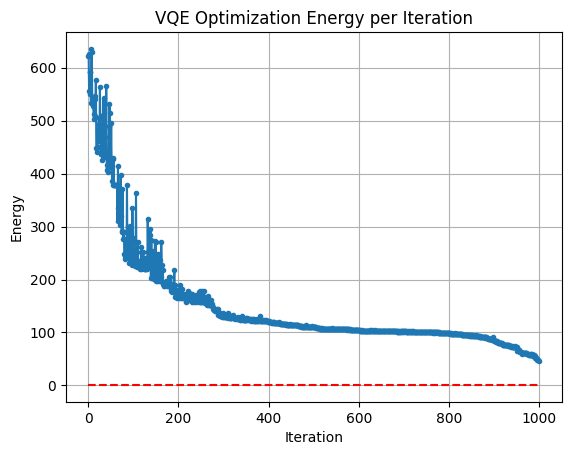

ITERATION 27 - seed = 69
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 104.34657598952175
Optimal parameters: [-1.73585445e-02  3.73861205e-01  3.09392644e+00  3.13245273e+00
  1.36916986e-02  3.14600407e+00  7.16626079e-01 -1.12399025e+00
 -1.52067696e+00  2.91071683e+00  1.46900993e+00  3.17975574e+00
  4.23638670e+00  2.04539281e+00 -2.74550097e+00  2.96406525e+00
  3.13603532e+00  1.85485363e+00  1.53206879e+00 -3.12033864e+00
 -4.41698252e+00 -2.30261688e-02  3.36287609e+00  1.08539667e+00
  3.75078199e+00 -1.14011878e+00  4.64821500e-02 -1.94727097e+00
 -1.43093460e-01  1.90343077e+00 -1.91809625e-02  1.90831581e+00
  3.10572420e+00 -8.49163411e-01  8.37003509e-02 -9.35600939e-02
  9.17414344e-01  2.19125499e+00  1.25215663e+00 -1.96855897e+00
  7.50916746e-01 -2.38316087e+00  4.40679635e-01  5.56454661e-01
  2.81024751e+00 -2.07410507e-01  2.78166732e+00 -1.12646367e+00
  3.43969282e-03  2.43742699e+00 -9.67183397e-01 -6.04625965e-01
  1.502871

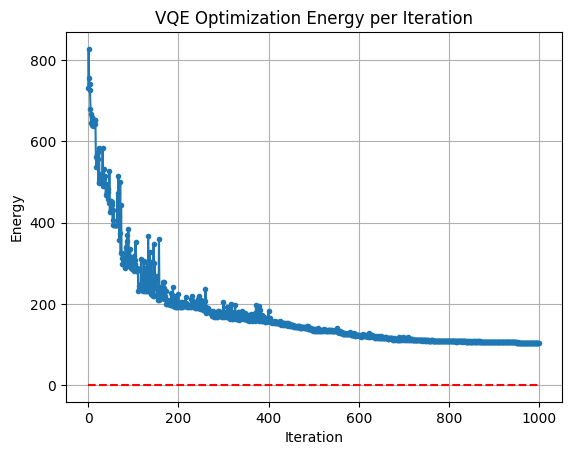

ITERATION 28 - seed = 70
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 102.1435393514421
Optimal parameters: [ 0.07386501  2.01054261 -0.00795276  3.16954556  0.0154431  -0.01858921
  0.18772649 -2.59799763  2.74790339 -2.22213278 -1.94629381 -1.04521276
 -1.32532166 -2.37709335 -0.1157749  -1.55246935  3.03985794 -1.80422899
 -2.36016768 -3.12774609 -1.5874104  -0.01233746  0.25726978 -2.19294957
 -2.099996    1.82961128 -0.92851613  0.88102206  0.10805925  0.35996095
 -0.36478512 -3.0499873   0.05585155 -0.46829208 -2.6101611   2.81723926
 -1.03567047 -0.95017106  1.59323333 -0.59772563 -1.71398731  1.15634557
 -1.39156132 -0.20731508 -0.83477163  0.74697674 -0.10551281  2.53745165
  3.19212694  0.22509821 -1.57114381 -2.66768228 -1.57459121  0.08495749
  4.55933887 -1.74436994  0.3433881  -2.89622773  0.94925859 -2.32770473
 -1.60581332 -0.22859997  0.99766025 -3.15701277]


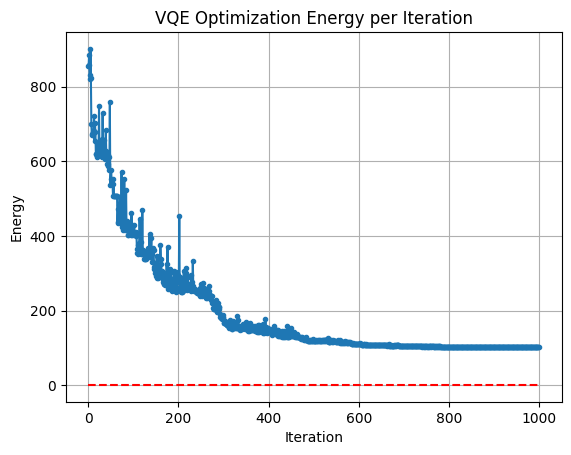

ITERATION 29 - seed = 71
No Ansatz Given, assuming EfficientSU2
NUMBER OF QUBITS 8 8
Ground state energy: 101.23984936322618
Optimal parameters: [-3.11723417  2.42403793  1.72959814  1.37709658 -1.15501663 -2.66999962
  1.98814454 -1.80642654  0.07355769 -2.99569057  3.13006415 -0.04201603
 -0.53648267  0.80741332  3.87404121 -1.56603023 -0.02869996  2.22683376
 -1.51609912 -1.5695087  -1.59485593 -1.45725292  1.5522     -1.19575513
  2.50253789  1.23921572 -0.50541002  2.78065837  4.02552915  0.35492888
  0.07477796  1.78157797 -0.0313616   0.11323666 -3.44050669  2.99039503
 -0.19854862  2.80357337  3.48807118 -2.35510651  4.76541684 -2.21679881
  0.73161618  2.62634709  0.71040742  2.38527044  0.3482018  -2.18860957
 -3.15604823  3.21551861 -0.11328322  3.18127943 -0.11757586  0.96835056
  1.52425385 -1.62632195 -0.04420061  3.51106879 -0.83911002  1.142709
  1.20951435 -3.40913968  0.6901083  -3.01856722]


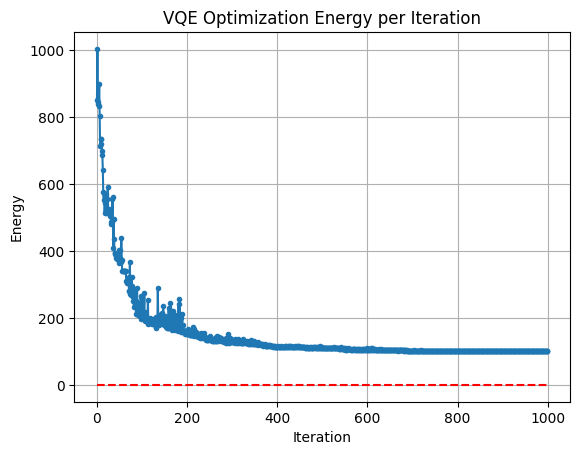

===== SUCCESS RATE FOR GLOBAL MINIMUM 4/30=13.333333333333334%


(4, 30)

In [11]:
from experiment_utils import *

# energy_values = []
# theta_path = []
# vqe_result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, maxiter=1000, seed=42)
# vqe_final_thetas = vqe_result.optimal_point
run_VQE_stats(H_total_JSP, min_eigenvalue.real, 30, maxiter=1000)

**Perturbed from Local Minimum**

In [1]:
# epsilons = np.linspace(0, 0.2, 3)
# average_distance_from_local_minimum = []
# std_distance_from_local_minimum = []
# average_final_score_function = []
# std_final_score_function = []
# #std as well

# for epsilon in epsilons:
#     distances = []
#     eigenvalues = []

#     for s in range(5): #average
#         #Just for sampling
#         np.random.seed(s)
#         perturbed_thetas = vqe_final_thetas + epsilon * np.random.uniform(-1, 1, len(vqe_final_thetas))

#         energy_values = []
#         theta_path = []
#         result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, initial_thetas=perturbed_thetas, maxiter=2000, seed=s, verbose=False)
        
#         distances += [np.linalg.norm(result.optimal_point-vqe_final_thetas)]
#         eigenvalues += [result.eigenvalue.real]
    
#     average_distance_from_local_minimum += [np.average(distances)]
#     std_distance_from_local_minimum += [np.std(distances)]
#     average_final_score_function += [np.average(eigenvalues)]
#     std_final_score_function += [np.std(eigenvalues)]

In [2]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# # Create the first plot: Average Distance from Local Minimum vs Epsilon
# plt.subplot(1, 2, 1)
# plt.plot(epsilons, average_distance_from_local_minimum, marker='o', linestyle='-', color='b', label='Average Distance')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  [avg + std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  color='b', alpha=0.2, label='Std Deviation')
# plt.title('Average Distance of the Final Point from Local Minimum vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Average Distance')
# plt.grid()
# plt.legend()

# # Create the second plot: Final Score vs Epsilon
# plt.subplot(1, 2, 2)
# plt.plot(epsilons, average_final_score_function, marker='o', linestyle='-', color='r', label='Average Final Score')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  [avg + std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  color='r', alpha=0.2, label='Std Deviation')
# plt.title('Final Eigenvalue vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Final Eigenvalue')
# plt.grid()
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()


In [3]:
# for i in range(4):
#     visualize_path_2d(theta_path, i, i+1)
# for i in range(4):
#     visualize_path_1d(theta_path, i)

**Running on MUB initial states**

NUMBER OF QUBITS 8 8
Ground state energy: 100.9109138461168
Optimal parameters: [-9.98330558e-03 -1.46866950e-02 -8.79191404e-01  1.09445733e+00
 -1.44281991e-02  7.92305076e-03  1.05522286e+00  4.66622153e-01
 -2.53783097e-03  4.87061955e-03  3.46865908e-02  1.32067041e-03
 -1.03401699e-01  1.10027152e+00  1.64966813e+00  8.83473941e-01
  7.71068175e-01  2.54507371e+00  1.56633566e+00  1.02312581e+00
  1.40481411e+00  1.21536662e-03  6.99588169e-01  1.45171165e-01
 -2.99719997e-03  1.51324640e+00  2.16575954e-01  1.72570922e+00
  1.08215945e-01  8.96090743e-01  1.58259583e+00  9.74947572e-01
  4.07251006e-02  7.17420594e-02  4.30363764e-01  3.32597136e-01
  8.08140416e-01  1.00182316e+00  1.36744266e+00  1.54027518e+00
  2.46049088e+00  7.06516442e-01  7.18862789e-03  9.81393386e-01
  1.31268245e+00 -1.20629956e-02  1.81337490e+00  2.92675918e-01
  6.11627730e-02  1.46486222e+00  2.68920502e-01  5.47833315e-01
  8.87796245e-01  9.38662382e-01  2.26445757e-01  8.50391198e-01]


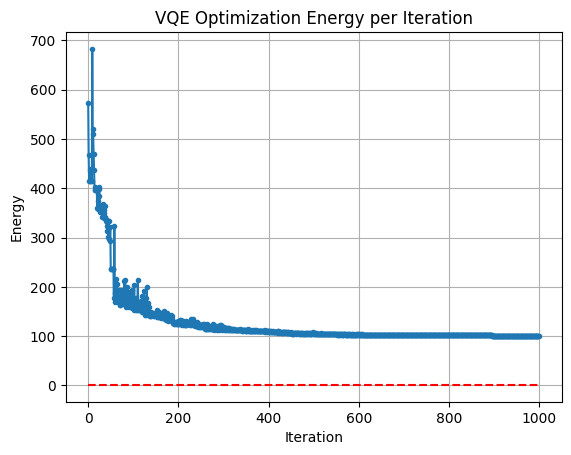

In [12]:
from experiment_utils import *
from vqe import *

energy_values = []
theta_path = []

run_VQE_MUB(H_total_JSP, min_eigenvalue.real, energy_values, theta_path, state_idx=3, mub_idx=2)
#TODO TODAY - make a function that goes through all triples and calls this function (for this, edit the permutation mask)

**All MUB states for first 2 qubits**

In [10]:
from experiment_utils import *

run_VQE_MUB_for_all_mubs_on_one_pair_2q(H_total_JSP, min_eigenvalue.real)
#run_VQE_MUB_on_subset(H_total_JSP, min_eigenvalue.real)

TypeError: 'NoneType' object is not iterable

ITERATION 0 === MUB VQE STATE on (np.int64(0), np.int64(1))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.92520307e-01  8.40127729e-01  1.07721313e-01
  1.45802182e+00  1.6948

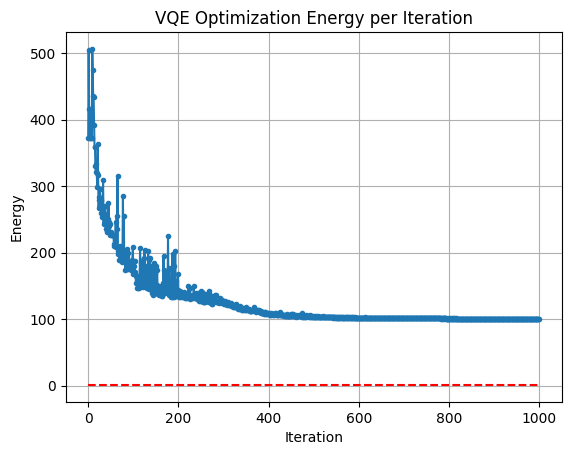

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

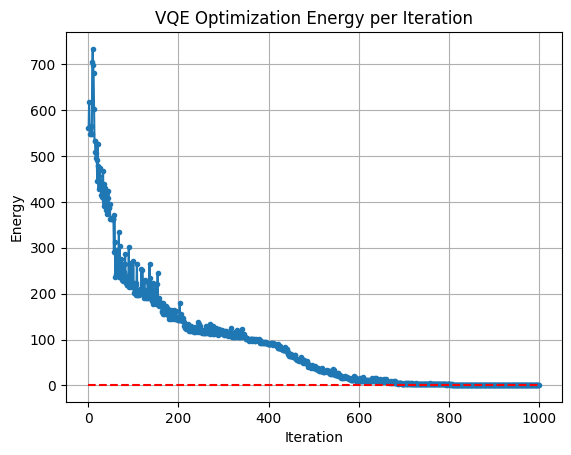

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

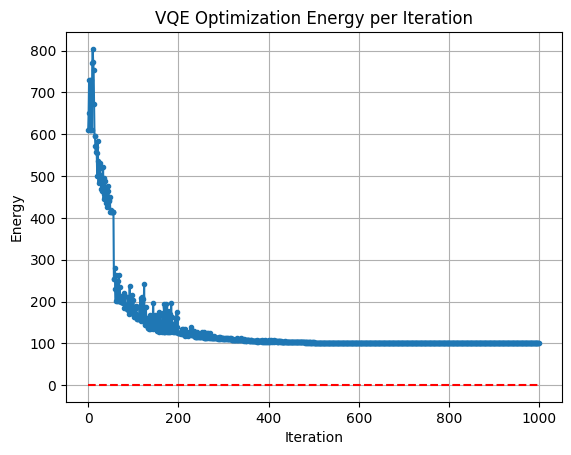

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

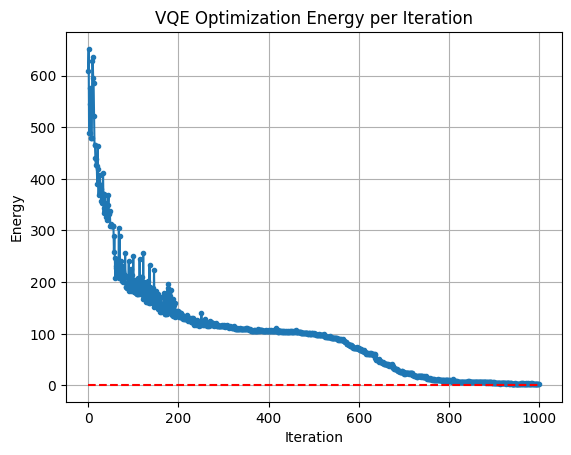

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 4 === MUB VQE STATE on (np.int64(0), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.

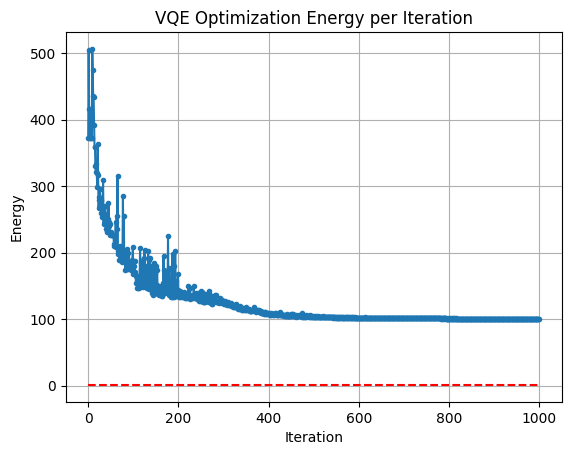

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

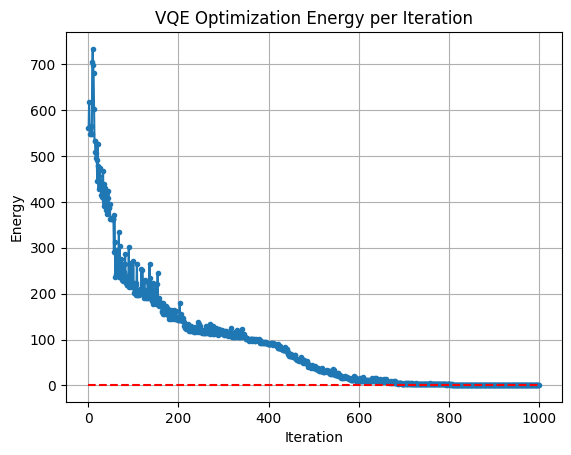

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

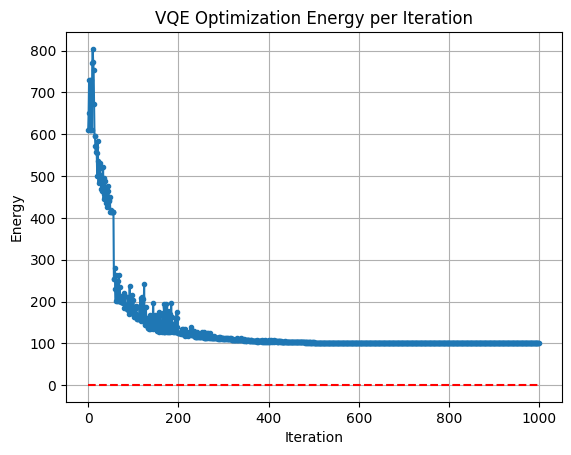

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

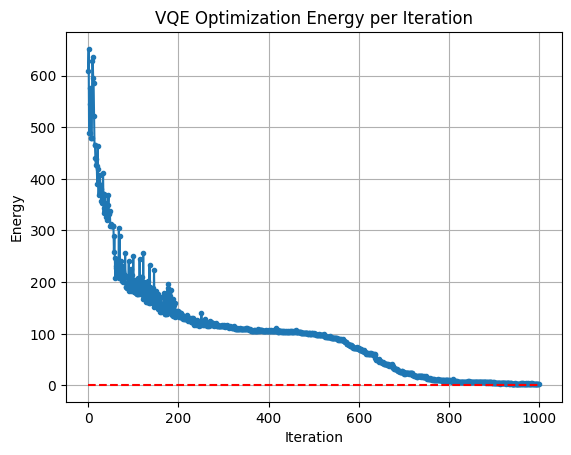

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 8 === MUB VQE STATE on (np.int64(0), np.int64(3))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8.

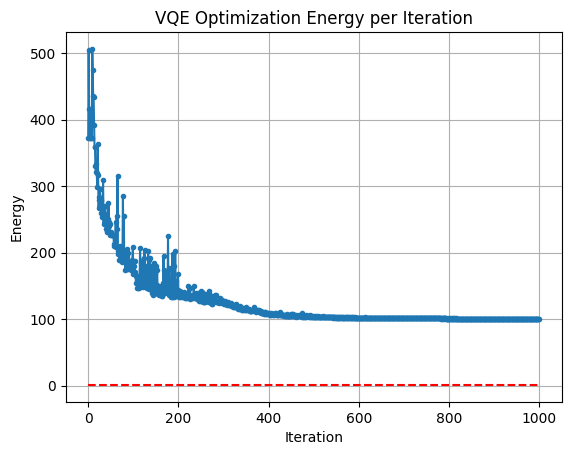

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

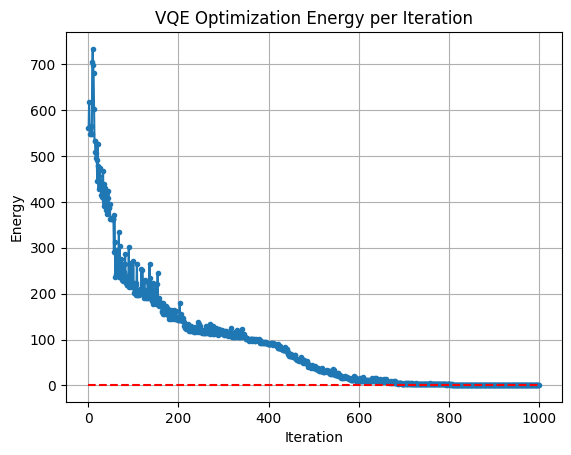

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

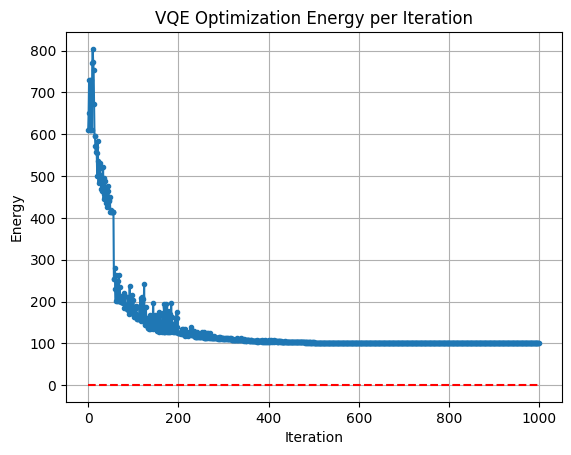

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

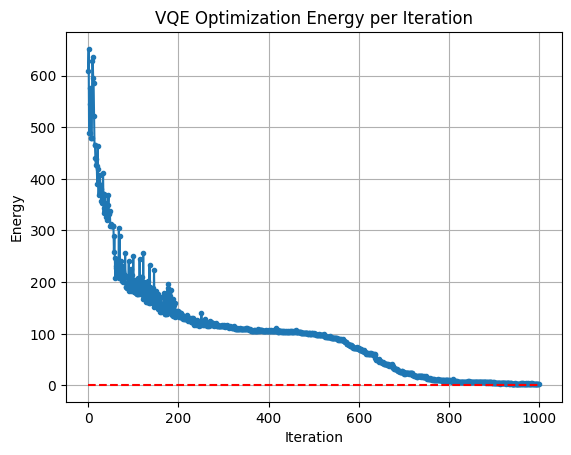

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 12 === MUB VQE STATE on (np.int64(0), np.int64(4))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

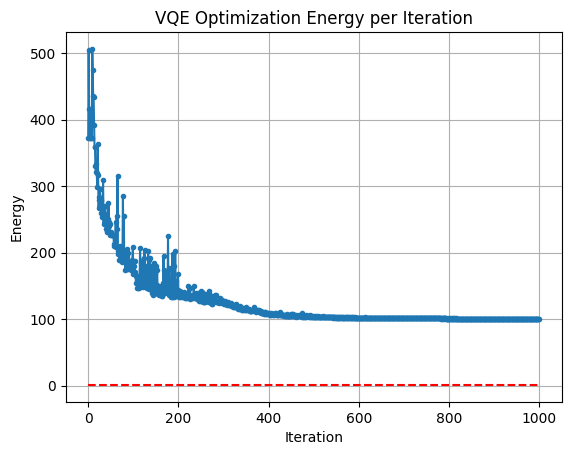

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

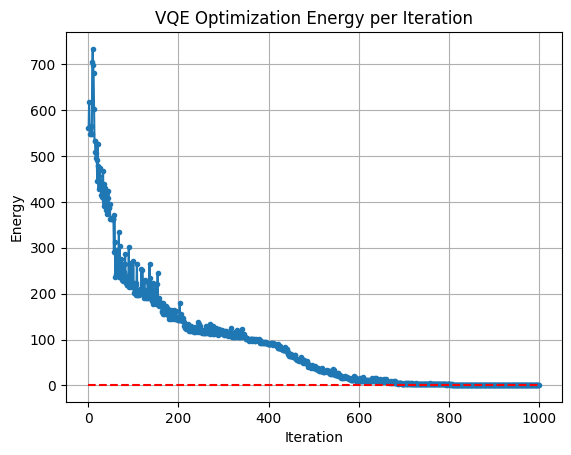

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

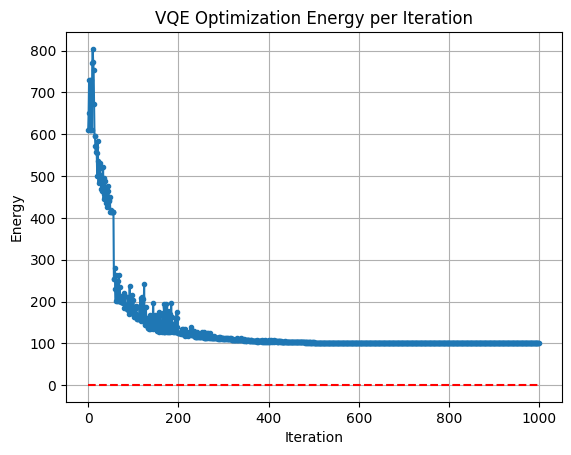

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

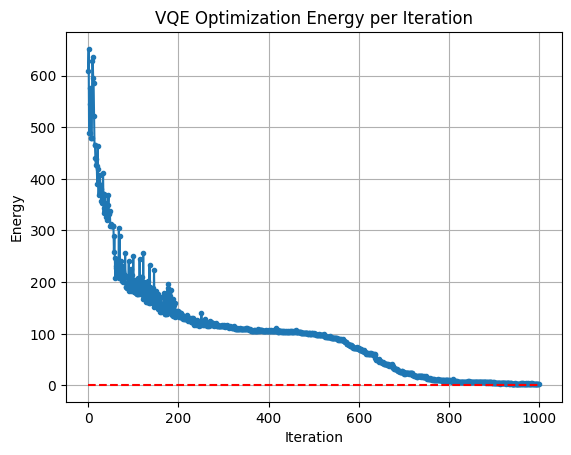

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 16 === MUB VQE STATE on (np.int64(0), np.int64(5))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

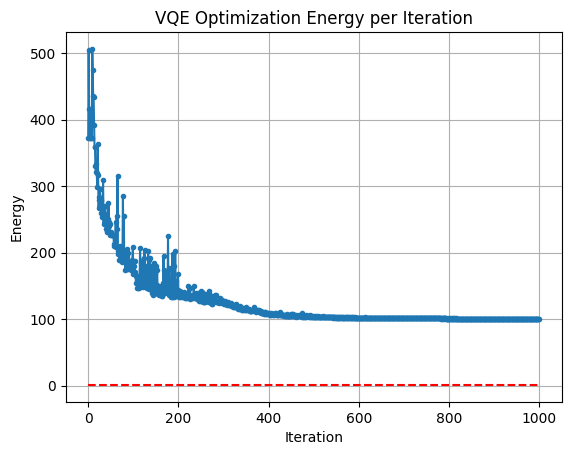

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

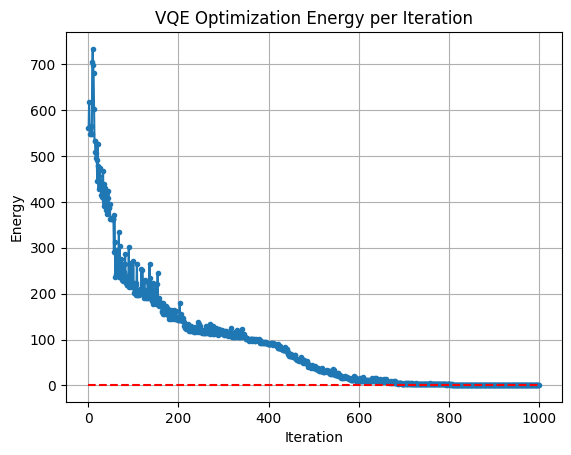

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

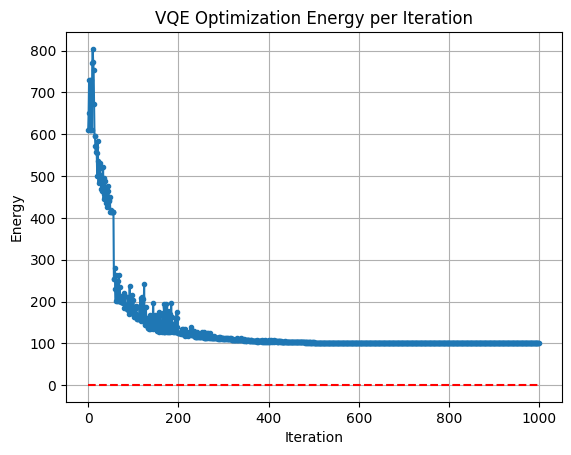

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

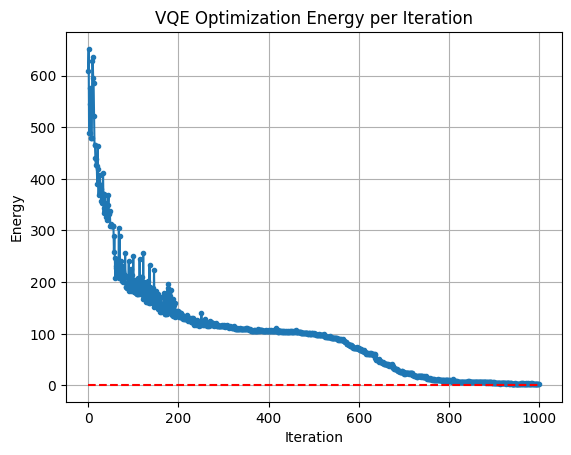

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 20 === MUB VQE STATE on (np.int64(0), np.int64(6))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

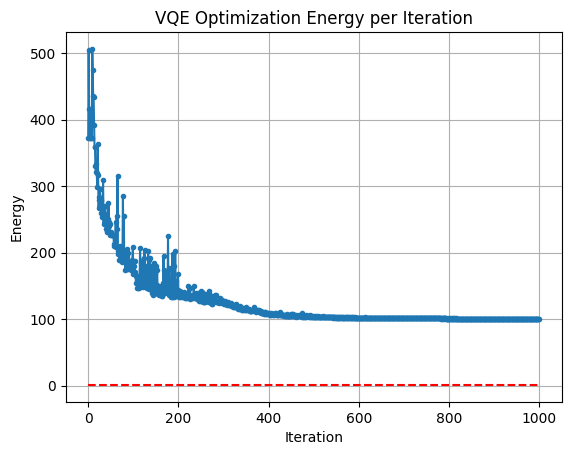

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

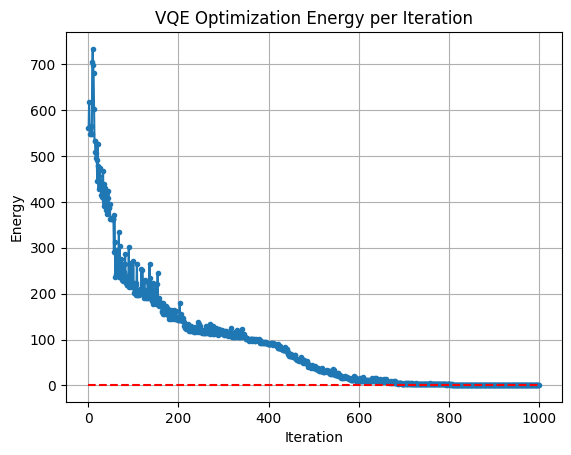

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

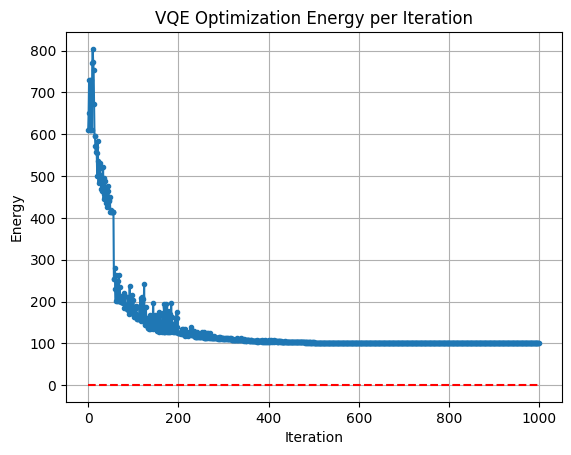

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

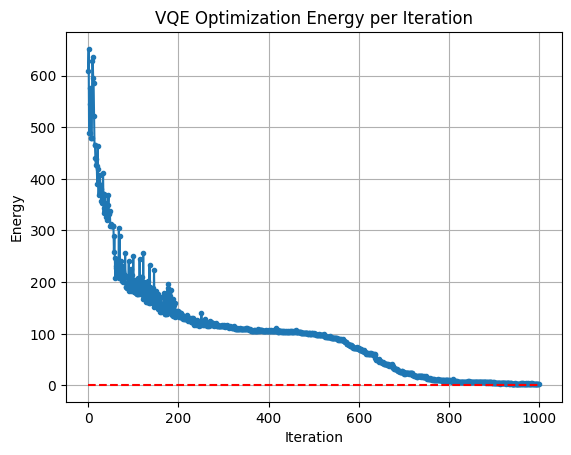

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 24 === MUB VQE STATE on (np.int64(0), np.int64(7))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

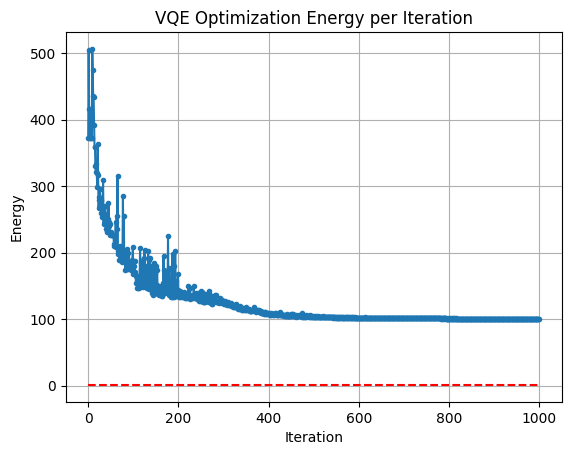

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

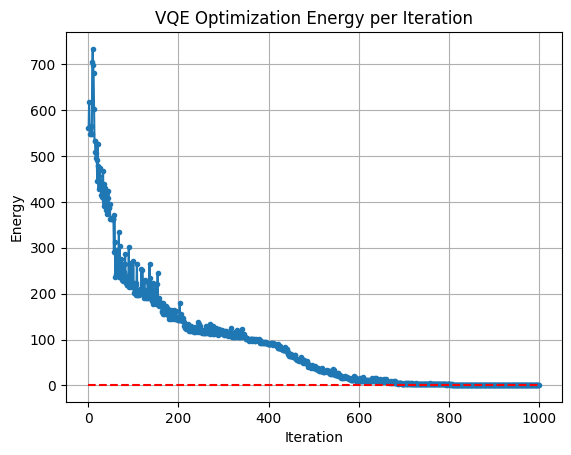

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

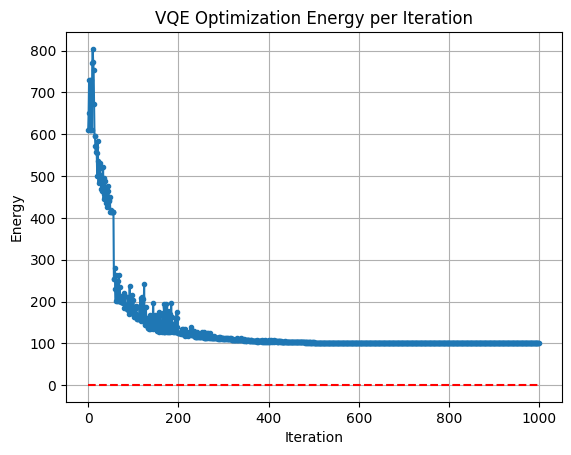

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

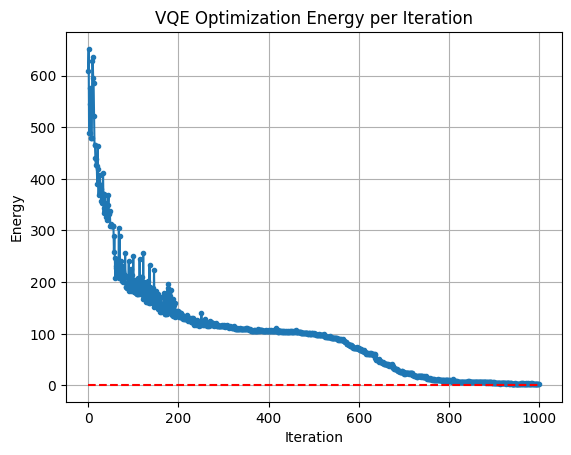

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 28 === MUB VQE STATE on (np.int64(1), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60695388438462
Optimal parameters: [-4.19979128e-04 -1.05924394e-01  1.47920719e+00  6.45644233e-01
  2.76718797e-03  9.72082865e-02  2.18013465e-01 -3.06670018e-01
 -4.93001325e-03  1.49876156e+00  8.86288752e-03  6.11843190e-01
 -5.86108686e-01  1.07034104e+00  1.91904066e+00  1.19148349e+00
 -1.15956555e-01  1.83399380e+00  9.40241502e-01  2.43601676e+00
 -4.37658843e-03 -1.07751617e-01  1.64979744e+00  2.83129218e-01
  8.43616397e-01 -5.19667115e-01  3.58545984e-02  3.36843694e-02
  2.11552418e+00 -6.00357948e-01  1.59301734e+00  6.00870788e-01
 -9.71392636e-03  1.30353220e+00  3.64769660e-01  1.06694089e+00
  1.06783069e+00 -2.13965969e-02  7.68701287e-01  2.04008981e+00
  8.20311904e-01  1.55498188e+00  1.08563893e+00  3.57321821e-01
  9.63071031e-03  8

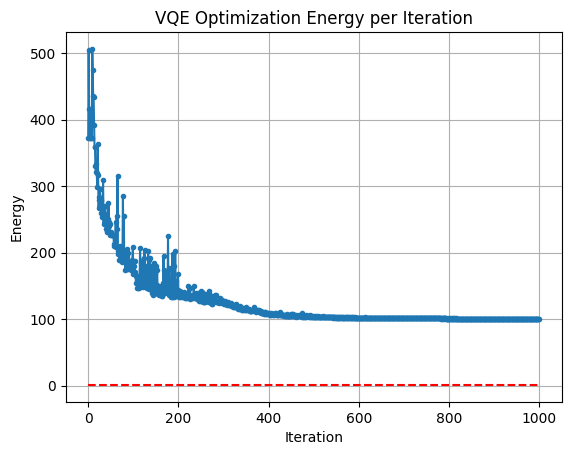

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 1.0782076201819049
Optimal parameters: [-1.27714241e-01  6.82390759e-01 -3.16267624e-01  3.73033094e-02
  3.21635353e+00 -6.76777771e-01  5.90265055e-01  6.56969835e-01
  4.15509314e-04 -1.14710176e-03  9.88767974e-04 -8.21944822e-04
  1.74138630e-01  2.19312690e+00 -1.19664836e-01  1.07625715e+00
  1.22257727e+00  2.05059965e+00  2.14656596e+00  2.86323805e+00
  5.19802823e-04  6.42092504e-03  6.94092675e-03  3.07327390e-03
  3.99274765e-01  1.30669104e+00  8.05117947e-02  9.71817787e-01
  1.41766810e+00  1.28560941e+00  2.55313405e+00 -7.57161843e-01
 -2.13278735e-01  3.13979198e+00  1.35747652e-03 -3.11010981e-03
  6.45414881e-01 -4.52177184e-01  2.59183217e+00  8.41497675e-02
  8.40779711e-01  1.62301470e+00  1.59414622e-01  8.27116988e-01
  1.68142445e-02 -1.37485135e-02  3.12542460e+00 -8.03280665e-03
  9.69182011e-01  1.05051197e+00 -2.55914163e-01  9.11923026e-01
 -3.68221625e-01  8

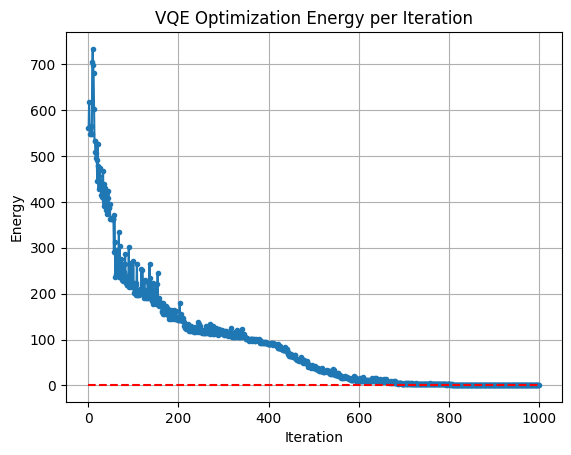

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
NUMBER OF QUBITS 8 8
Ground state energy: 100.60619611679782
Optimal parameters: [-1.10609207e-03 -3.06964025e-02  1.05357709e+00 -6.80085150e-01
 -2.19495233e-03  2.13414107e-02 -7.37755302e-01 -2.85195414e-01
  9.94761530e-04  1.59390510e+00  1.41267521e-02  1.00613724e-01
 -6.45799002e-01  1.59009701e+00  2.41467649e-01  7.89714426e-02
  1.99568966e+00  2.03007975e+00  7.65243993e-01  2.27006686e+00
 -1.45199048e-05  1.42140834e+00  1.41339417e+00  1.08365557e-01
  6.80744169e-01  8.21729331e-01 -1.90184493e-01  1.57042540e+00
  1.50060114e+00  1.00368916e+00  1.36029649e+00  6.06516231e-01
 -3.89066795e-03  1.91378364e+00 -5.17988149e-03  1.16961106e+00
  2.56577048e-01  3.86523548e-01  1.37321630e+00  1.59690110e+00
  1.40704857e+00  9.93818349e-01  1.02018172e+00  4.69321929e-01
  3.37396259e-03 -1.47288670e-02 -6.98024493e-02 -1.20734604e-01
  1.24410976e+00  8.84973905e-01  1.70057046e+00  5.35457285e-0

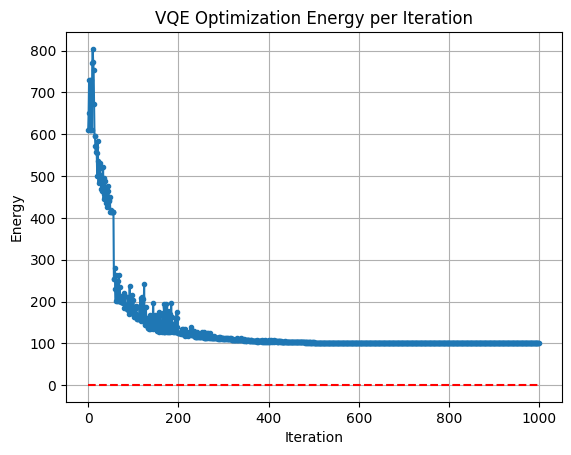

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
NUMBER OF QUBITS 8 8
Ground state energy: 2.6876669265744644
Optimal parameters: [-4.19741795e-01 -2.10288468e+00  5.03620093e-01  5.34384046e-02
  2.78120286e+00  2.09099740e+00  1.22186915e+00 -1.63444962e+00
 -1.43624211e-02  1.68001148e-02  1.26813171e-02 -1.44857470e-02
  1.53774753e-02  1.54727506e+00  2.31493603e-01  8.06268614e-01
  1.23332140e+00  1.35770700e+00  3.86805154e-01  2.29173135e+00
  4.23411923e-03  7.17066802e-04 -7.55209543e-02  7.05580606e-03
  5.76380359e-01  8.94862651e-02 -1.58235542e-01  6.54189774e-01
  1.76386702e+00 -1.52044015e+00  2.25913121e+00  7.91836349e-01
 -3.36824917e-01  3.18235964e+00  1.83419341e-02 -4.03821295e-03
  4.76665750e-01 -5.42465210e-02  1.51409568e+00  1.58186326e+00
  5.24624405e-01  1.15437303e+00  5.68477192e-01  2.93662921e-02
  4.40705664e-02  2.86569780e-02  3.07184130e+00  2.44612380e-02
  9.52779708e-01  1.50093167e+00  1.15106458e+00  3.79162342e-01
  1.89858206e+00  1

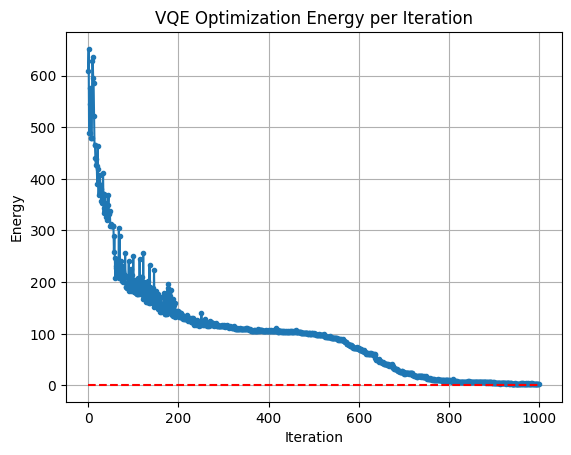

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
===== TOTAL SUCCESS RATE FOR GLOBAL MINIMUM 16/32=50.0%


(16, 32)

In [11]:
run_VQE_MUB_for_all_choose_2q(H_total_JSP, min_eigenvalue.real, 30, list(itertools.product(range(2), range(2))))

In [1]:
# from experiment_utils import *
# from qiskit_aer import Aer

# #Test that this is the MUB state:
# ansatz, thetas = get_mub_ansatz_and_thetas(8, state_idx=1, mub_idx=4, MUB_mask=None)

# qc = ansatz.assign_parameters(thetas)
# print(qc)
#print(parameter_dict_to_list(thetas, ansatz))
##

# # Simulate the circuit
# # backend = Aer.get_backend('statevector_simulator')
# # job = backend.run(qc)
# # result = job.result()
# # statevector = result.get_statevector()

In [2]:
# def vector_to_spherical_angles(v):
#     # Ensure the input is a numpy array and normalized
#     v = np.asarray(v)
#     assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
#     n = len(v)
#     angles = np.zeros(n - 1)

#     # Calculate the angles
#     for i in range(0, n - 1):
#         # Calculate the angle theta_i
#         # Use the norm of the remaining dimensions
#         norm_remaining = np.linalg.norm(v[i+1:])
#         angles[i] = np.arctan2(norm_remaining, v[i])
    
#     return angles

# def spherical_angles_to_vector(angles):
#     # Ensure the input is a numpy array
#     angles = np.asarray(angles)
#     n = len(angles) + 1  # Number of dimensions
    
#     # Initialize the unit vector
#     v = np.zeros(n)
    
#     # Calculate the first coordinate
#     v[0] = np.cos(angles[0])
    
#     # Calculate the remaining coordinates
#     for i in range(1, n):
#         # Compute the product of sines for the previous angles
#         if i < n - 1:
#             sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
#             v[i] = sin_product * np.cos(angles[i])
#         else:
#             # For the last coordinate, we use the product of sines for all previous angles
#             v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

#     return v

# test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
# print(vector_to_spherical_angles(test_v))
# print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

# def get_directions(v, step_size):
#     # Ensure the input is a numpy array
#     v = np.asarray(v)
#     directions = []
    
#     # Iterate over each element in the vector
#     for i in range(len(v)):
#         # Create a copy of the original vector
#         v_plus = v.copy()
#         v_minus = v.copy()
        
#         # Modify the i-th element
#         v_plus[i] += step_size
#         v_minus[i] -= step_size
        
#         # Append the new vectors to the directions list
#         directions.append(v_plus)
#         directions.append(v_minus)
    
#     return directions

# def optimizer(H, initial_guess, step_size=0.01):
#     best_vector_angles = vector_to_spherical_angles(initial_guess)
#     print(best_vector_angles)
#     best_value = get_eigenvalue_sparse(initial_guess, H)
#     print(best_value)
    
#     for iterations in range(500):
#         #Pick best direction
#         for nearby_step in get_directions(best_vector_angles, step_size):
#             new_value = get_eigenvalue_sparse(spherical_angles_to_vector(nearby_step), H)
#             print("direction")
#             if(best_value > new_value):
#                 best_value = new_value
#                 best_vector_angles = nearby_step
#         print(best_vector_angles)
    
#     return best_value, spherical_angles_to_vector(best_vector_angles)

In [3]:
# from scipy.sparse import diags

# H_diag_sparse = diags(H_diag.reshape(-1,))
# initial = np.zeros(shape=(H_diag.shape[0],))
# initial[0] = 1

# optimizer(H_diag, initial)

In [4]:
# **Quantum Exhaustive Binary Search - QEBS**
# from hamiltonians import get_expectation_value
# from qiskit.quantum_info import Statevector

# state_string = "+" * task.num_qubits

# for i in range(task.num_qubits):
#     #If 0
#     state_string_if_0 = state_string[:i] + "0" + state_string[i+1:]
#     state_if_0 = initialize_state_from_string(state_string_if_0)
#     #If 1
#     state_string_if_1 = state_string[:i] + "1" + state_string[i+1:]
#     state_if_1 = initialize_state_from_string(state_string_if_1)
#     print(get_expectation_value(state_if_0, H_total_JSP), get_expectation_value(state_if_1, H_total_JSP))
#     if get_expectation_value(state_if_0, H_total_JSP) >= get_expectation_value(state_if_1, H_total_JSP):
#         state_string = state_string_if_1
#     else:
#         state_string = state_string_if_0

# final_state = initialize_state_from_string(state_string)

# print("Naive solution", state_string)

In [ ]:
# **Simulated Annealing binary search**
# def simulated_annealing_binary_search(hamiltonian, n, max_iterations, debug=True):
#     # Initialize an empty prefix and a dictionary to track prefixes and their values
#     prefixes = {"":1}
#     best_solution = None
#     best_solution_value = 1e9

#     average_value = get_expectation_value(initialize_state_from_string("+" * n), hamiltonian)

#     for _ in range(max_iterations):
#         if len(prefixes) == 0:
#             break

#         # Sample a prefix with probability proportional to exp(-value(prefix))
#         total_value = sum(np.exp(-value / average_value) for value in prefixes.values())
#         probabilities = [np.exp(-value / average_value) / total_value for value in prefixes.values()]
        
#         # Sample a prefix based on the calculated probabilities
#         sampled_prefix = np.random.choice(list(prefixes.keys()), p=probabilities)
#         print(f"Sampled {sampled_prefix}") if debug else None
#         del prefixes[sampled_prefix]

#         # Check the value of adding a '0' to the sampled prefix
#         prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "0"] = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             best_solution = sampled_prefix + "0"
#             print(f"Landed on final state {best_solution}") if debug else None

#         # Check the value of adding a '1' to the sampled prefix
#         prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "1"] = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             best_solution = sampled_prefix + "1"
#             print(f"Landed on final state {best_solution}") if debug else None

#         print(prefixes) if debug else None
#         #print("normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])

#     # Return the most valuable prefix or any other relevant information
#     if best_solution == None or (len(prefixes) > 0 and best_solution_value > min(prefixes.values())):
#         proposed_solution = min(prefixes, key=prefixes.get)
#     else:
#         proposed_solution = best_solution
    

#     if len(proposed_solution) < n:
#         for _ in range(n - len(proposed_solution)):
#             values, keys = np.array(list(prefixes.values())), np.array(list(prefixes.keys()))
#             sampled_prefix = keys[np.argmin(values)]

#             print(f"Greedy Sampled {sampled_prefix}") if debug else None
#             del prefixes[sampled_prefix]

#             # Check the value of adding a '0' to the sampled prefix
#             prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_zero_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "0"] = prefix_with_zero_value
            
#             # Check the value of adding a '1' to the sampled prefix
#             prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_one_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "1"] = prefix_with_one_value

#             if len(sampled_prefix) + 1 == n:
#                 if prefix_with_zero_value < prefix_with_one_value:
#                     return sampled_prefix + "0"
#                 else:
#                     return sampled_prefix + "1"

#             print("Greedy", prefixes) if debug else None
#             #print("Greedy normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])
#     else:
#         return proposed_solution

# print("Found Solution", simulated_annealing_binary_search(H_total_JSP, task.num_qubits, 4))

In [ ]:
#**Benchmark - Probability of success vs number of iterations**
# N_MAX = 20
# iter_nums = list(range(2, 6))
# probabilities = []

# for iter_num in iter_nums:
#     success = 0
#     for N in range(N_MAX):
#         if simulated_annealing_binary_search(H_total_JSP, task.num_qubits, iter_num, debug=False) == binary_solution:
#             success += 1
#     probabilities += [success / N_MAX]

# print(probabilities)
# plt.plot(iter_nums, probabilities, marker='.')
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability of finding the optimal solution")

# plt.show()